In [1]:
import os
# set GPU number. This might work for several framework such as PyTorch, TensorFlow, Keras
gpu_id = '1'
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_id

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# sys.path.append('../../loglizer')
    
# from loglizer import dataloader
# from loglizer.preprocessing import Vectorizer, Iterator
import sys
import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim
from torch.utils.data import Dataset
import torch.utils.data as Data
import pickle as pkl
import argparse
import time
import copy
import torchvision.transforms as transforms
import torchvision
import random
from collections import OrderedDict
from PIL import Image

import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from collections import defaultdict

In [4]:
# struct_log = '../data/HDFS/HDFS.log_structured.csv' # The structured log file

#初始參數
class Parser():
    def __init__(self):
        self.mode = 'fedavg'  #FedBN,FedAvg,fedprox,fedopt,fedadagrad,fedadam 待加入scoffold
        #所有方法都有使用Fedbn
        self.beta_1 = 0.9
        self.beta_2 = 0.99 #b1,b2 for adaptive opt
        self.tau = 1e-2
        self.batch = 32
        self.lr = 1e-1
        self.server_lr = 1e-1
        self.server_momentum = 0.5
        self.client_momentum = 0.9 # 0 is fedavg others is fedavgm
        self.no_cuda = False
        self.seed = 1
        self.client_num = 5
        self.wk_iters = 1 # training
        self.num_workers = 2 # dataloader
        self.mu = 1e-3
        self.iters = 50 #epochs
        self.local_epochs = 1
        self.server_opt = 'sgd'
        self.percent = 1
#         self.early_stop = 500
        self.window_size = 10
        self.train_ratio = 0.5
        self.split_type='sequential' # sequential, uniform

        
args = Parser()

use_cuda = not args.no_cuda and torch.cuda.is_available()
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed) 
random.seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")

In [5]:
sys.path.append('../')
from logdeep.tools.predict_sl import Predicter
from logdeep.tools.train_sl import Trainer
from logdeep.tools.utils import *

# Config Parameters

options = dict()
options['data_dir'] = '../data/'
options['window_size'] = 10
options['device'] = device

# Smaple
options['sample'] = "sliding_window"
options['window_size'] = 10  # if fix_window

# Features
options['sequentials'] = True
options['quantitatives'] = False
options['semantics'] = False
options['feature_num'] = sum(
    [options['sequentials'], options['quantitatives'], options['semantics']])

# Model
options['input_size'] = 1
options['hidden_size'] = 64
options['num_layers'] = 2
options['num_classes'] = 28

# Train
options['batch_size'] = 2048
options['accumulation_step'] = 1

options['optimizer'] = 'adam'
options['lr'] = 1e-2
options['max_epoch'] = args.local_epochs
options['lr_step'] = (300, 350)
options['lr_decay_ratio'] = 0.1

options['resume_path'] = None
options['model_name'] = "deeplog"
options['save_dir'] = "../result/deeplog/"

# Predict
options['model_path'] = "../result/deeplog/deeplog_last.pth"
options['num_candidates'] = 9

seed_everything(seed=1234)


def train():
    trainer = Trainer(Model, options)
    trainer.start_train()


def predict():
    predicter = Predicter(Model, options)
    predicter.predict_unsupervised()

# Preprocessing

In [6]:
# https://github.com/abedicodes/FedSL/blob/master/models/Networks.py
# model改兩個的話，train的部份也要改
# 隨時小心forward 跟 backward有沒有都對上
class deeplog(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_keys):
        super(deeplog, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, num_keys)

    def forward(self, features, device):
        input0 = features[0]
        h0 = torch.zeros(self.num_layers, input0.size(0),
                         self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, input0.size(0),
                         self.hidden_size).to(device)
        out, _ = self.lstm(input0, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

class deeplog_1st(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_keys):
        super(deeplog_1st, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            batch_first=True)
#         self.fc = nn.Linear(hidden_size, num_keys)

    def forward(self, features, device):
        input0 = features[0]
        h0 = torch.zeros(self.num_layers, input0.size(0),
                         self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, input0.size(0),
                         self.hidden_size).to(device)
        out, (outpreh, outprec) = self.lstm(input0, (h0, c0))
#         out = self.fc(out[:, -1, :])
        return out, outpreh, outprec


class deeplog_2nd(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_keys):
        super(deeplog_2nd, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, num_keys)

    def forward(self, features, hPrevious, cPrevious, device):
        input0 = features[0]
#         h0 = torch.zeros(self.num_layers, input0.size(0),
#                          self.hidden_size).to(device)
#         c0 = torch.zeros(self.num_layers, input0.size(0),
#                          self.hidden_size).to(device)
        out, _ = self.lstm(input0,  (hPrevious, cPrevious))
        out = self.fc(out[:, -1, :])
        return out 

# Federated learning

In [7]:
def communication(args, server_model_1, server_model_2, models_1, models_2, client_weights, v_1, v_2, grad_1, grad_2):
    if args.mode.lower() == 'fedbn':
        with torch.no_grad():
            for key in server_model_1.state_dict().keys():
                if 'bn' not in key: #非BN層都去交換
                    temp = torch.zeros_like(server_model_1.state_dict()[key], dtype=torch.float32)
                    for client_idx in range(client_num):
                        temp += client_weights[client_idx] * models_1[client_idx].state_dict()[key]
                    server_model_1.state_dict()[key].data.copy_(temp)
                    for client_idx in range(client_num):
                        models_1[client_idx].state_dict()[key].data.copy_(server_model_1.state_dict()[key])
            for key in server_model_2.state_dict().keys():
                if 'bn' not in key: #非BN層都去交換
                    temp = torch.zeros_like(server_model_2.state_dict()[key], dtype=torch.float32)
                    for client_idx in range(client_num):
                        temp += client_weights[client_idx] * models_2[client_idx].state_dict()[key]
                    server_model_2.state_dict()[key].data.copy_(temp)
                    for client_idx in range(client_num):
                        models_2[client_idx].state_dict()[key].data.copy_(server_model_2.state_dict()[key])
    
    elif args.mode.lower() == 'fedadagrad':
        with torch.no_grad():
            for key, param in server_model_1.named_parameters():
                temp = torch.zeros_like(server_model_1.state_dict()[key])
                for client_idx in range(len(client_weights)):
                    temp = temp + client_weights[client_idx] * models_1[client_idx].state_dict()[key]                          
                param.grad = temp - param.data              
                param.grad = torch.mul(grad_1[key], args.beta_1) + torch.mul(param.grad, 1-args.beta_1)
                grad_1[key] = param.grad
                v_1[key] = v_1[key] + param.grad**2
                param.data = param.data + torch.mul(torch.div(param.grad, torch.add(torch.sqrt(v_1[key]),args.tau)), args.server_lr) 

                for client_idx in range(len(client_weights)):
                    models_1[client_idx].state_dict()[key].data.copy_(server_model_1.state_dict()[key])                         
            for key, param in server_model_2.named_parameters():
                temp = torch.zeros_like(server_model_2.state_dict()[key])
                for client_idx in range(len(client_weights)):
                    temp = temp + client_weights[client_idx] * models_2[client_idx].state_dict()[key]                          
                param.grad = temp - param.data              
                param.grad = torch.mul(grad_2[key], args.beta_1) + torch.mul(param.grad, 1-args.beta_1)
                grad_2[key] = param.grad
                v_2[key] = v_2[key] + param.grad**2
                param.data = param.data + torch.mul(torch.div(param.grad, torch.add(torch.sqrt(v_2[key]),args.tau)), args.server_lr) 

                for client_idx in range(len(client_weights)):
                    models_2[client_idx].state_dict()[key].data.copy_(server_model_2.state_dict()[key]) 
    
    elif args.mode.lower() == 'fedadam':
        with torch.no_grad():
            for key, param in server_model_1.named_parameters():                
                temp = torch.zeros_like(server_model_1.state_dict()[key])
                for client_idx in range(len(client_weights)):
                    temp += client_weights[client_idx] * models_1[client_idx].state_dict()[key]                         
                param.grad = temp - param.data              
                param.grad = torch.mul(grad_1[key], args.beta_1) + torch.mul(param.grad, 1-args.beta_1) 
                grad_1[key] = param.grad                
                v_1[key] = torch.mul(v_1[key], args.beta_2) + torch.mul(param.grad**2, 1-args.beta_2)
                param.data = param.data + torch.mul(torch.div(param.grad, torch.add(torch.sqrt(v_1[key]),args.tau)), args.server_lr)
                
                for client_idx in range(len(client_weights)):
                    models_1[client_idx].state_dict()[key].data.copy_(server_model_1.state_dict()[key])
            for key, param in server_model_2.named_parameters():                
                temp = torch.zeros_like(server_model_2.state_dict()[key])
                for client_idx in range(len(client_weights)):
                    temp += client_weights[client_idx] * models_2[client_idx].state_dict()[key]                         
                param.grad = temp - param.data              
                param.grad = torch.mul(grad_2[key], args.beta_1) + torch.mul(param.grad, 1-args.beta_1) 
                grad_2[key] = param.grad                
                v_2[key] = torch.mul(v_2[key], args.beta_2) + torch.mul(param.grad**2, 1-args.beta_2)
                param.data = param.data + torch.mul(torch.div(param.grad, torch.add(torch.sqrt(v_2[key]),args.tau)), args.server_lr)
                
                for client_idx in range(len(client_weights)):
                    models_2[client_idx].state_dict()[key].data.copy_(server_model_2.state_dict()[key])

    else:
        with torch.no_grad():
            for key in server_model_1.state_dict().keys():#遇到BN層就直接拿第一個client參數使用
                # num_batches_tracked is a non trainable LongTensor and
                # num_batches_tracked are the same for all clients for the given datasets
                if 'num_batches_tracked' in key:
                    server_model_1.state_dict()[key].data.copy_(models_1[0].state_dict()[key])
                else:
                    temp = torch.zeros_like(server_model_1.state_dict()[key]).to(device)
                    for client_idx in range(len(client_weights)):
                        temp += client_weights[client_idx] * models_1[client_idx].state_dict()[key]                        
                    server_model_1.state_dict()[key].data.copy_(temp)#weight傳給server
                    for client_idx in range(len(client_weights)):
                        models_1[client_idx].state_dict()[key].data.copy_(server_model_1.state_dict()[key])  
            for key in server_model_2.state_dict().keys():#遇到BN層就直接拿第一個client參數使用
                # num_batches_tracked is a non trainable LongTensor and
                # num_batches_tracked are the same for all clients for the given datasets
                if 'num_batches_tracked' in key:
                    server_model_2.state_dict()[key].data.copy_(models_2[0].state_dict()[key])
                else:
                    temp = torch.zeros_like(server_model_2.state_dict()[key]).to(device)
                    for client_idx in range(len(client_weights)):
                        temp += client_weights[client_idx] * models_2[client_idx].state_dict()[key]                        
                    server_model_2.state_dict()[key].data.copy_(temp)#weight傳給server
                    for client_idx in range(len(client_weights)):
                        models_2[client_idx].state_dict()[key].data.copy_(server_model_2.state_dict()[key])  
    return server_model_1, server_model_2, models_1, models_2, v_1, v_2, grad_1, grad_2

In [8]:
# # setup model
server_model_1 = deeplog_1st(input_size=options['input_size'],
                    hidden_size=options['hidden_size'],
                    num_layers=options['num_layers'],
                    num_keys=options['num_classes']).to(device)
server_model_2 = deeplog_2nd(input_size=options['input_size'],
                    hidden_size=options['hidden_size'],
                    num_layers=options['num_layers'],
                    num_keys=options['num_classes']).to(device)

# for adaptive velocity
v_1 = {}
grad_1 = {}
v_2 = {}
grad_2 = {}

for key in server_model_1.state_dict().keys():
    v_1[key] = torch.add(torch.zeros_like(server_model_1.state_dict()[key],dtype=torch.float32),args.tau**2)
    grad_1[key] = torch.zeros_like(server_model_1.state_dict()[key],dtype=torch.float32)
for key in server_model_2.state_dict().keys():
    v_2[key] = torch.add(torch.zeros_like(server_model_2.state_dict()[key],dtype=torch.float32),args.tau**2)
    grad_2[key] = torch.zeros_like(server_model_2.state_dict()[key],dtype=torch.float32)
    

# name of each datasets
datasets = ['Client'+str(i) for i in range(args.client_num)]
# federated client number
client_num = len(datasets)
client_weights = [1/client_num for i in range(client_num)]
# each local client model
models_1 = [copy.deepcopy(server_model_1).to(device) for idx in range(client_num)]
models_2 = [copy.deepcopy(server_model_2).to(device) for idx in range(client_num)]

start_iter = 0

lloogg_1 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}
lloogg_2 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}
lloogg_3 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}
lloogg_4 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}
lloogg_5 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}

result_recall = {}
result_precision = {}
result_f1 = {}
result_acc = {}
for i in range(client_num):
    result_recall[i] = []
    result_precision[i] = []
    result_f1[i] = []
    result_acc[i] = []

# Start training
for a_iter in range(start_iter, args.iters):
#     optimizers = [optim.SGD(params = models[idx].parameters(), lr=args.lr, momentum = args.client_momentum) for idx in range(client_num)]
    for wi in range(args.wk_iters):
        print("============ Train epoch {} ============".format(wi + a_iter * args.wk_iters))
        for client_idx in range(args.client_num):
            print('Client ', client_idx)
            trainer = Trainer(models_1[client_idx], models_2[client_idx], options, args.client_num, client_idx)
            trainer.start_train()
            
            exec('lloogg_'+str(client_idx+1)+"['train']['epoch'].append(a_iter)")
            exec('lloogg_'+str(client_idx+1)+"['train']['lr'].append(trainer.log['train']['lr'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['train']['time'].append(trainer.log['train']['time'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['train']['loss'].append(trainer.log['train']['loss'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['val']['epoch'].append(a_iter)")
            exec('lloogg_'+str(client_idx+1)+"['val']['lr'].append(trainer.log['valid']['lr'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['val']['time'].append(trainer.log['valid']['time'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['val']['loss'].append(trainer.log['valid']['loss'][-1])")

    with torch.no_grad():
        # aggregation
        server_model_1, server_model_2, models_1, models_2, v_1, v_2, grad_1, grad_2 = communication(args, server_model_1, server_model_2, models_1, models_2, client_weights, v_1, v_2, grad_1, grad_2 )
        # Report loss after aggregation
        print("============ Test epoch {} ============".format(wi + a_iter * args.wk_iters))

        for client_idx in range(args.client_num):
            print('Client ', client_idx)
            predicter = Predicter(models_1[client_idx], models_2[client_idx], options, args.client_num, client_idx)
            predicter.predict_unsupervised()
            
            result_recall[client_idx].append(predicter.recall)
            result_precision[client_idx].append(predicter.precision)
            result_f1[client_idx].append(predicter.f1)
            result_acc[client_idx].append(predicter.acc)

============ Train epoch 0 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3326.09it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:22:15 | Learning rate: 0.000313


Train loss: 3.24905: 100%|██████████| 5/5 [00:00<00:00, 33.93it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:22:16 


: 100%|██████████| 1/1 [00:00<00:00, 68.66it/s]

Validation loss: 3.2218329906463623
Client  1


File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3238.60it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:22:28 | Learning rate: 0.000313


Train loss: 3.25015: 100%|██████████| 5/5 [00:00<00:00, 36.88it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:22:28 


: 100%|██████████| 1/1 [00:00<00:00, 88.89it/s]


Validation loss: 3.21799898147583
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3510.00it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:22:42 | Learning rate: 0.000313


Train loss: 3.25052: 100%|██████████| 5/5 [00:00<00:00, 44.13it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:22:42 


: 100%|██████████| 1/1 [00:00<00:00, 95.45it/s]


Validation loss: 3.223149299621582
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3281.76it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:22:55 | Learning rate: 0.000313


Train loss: 3.24985: 100%|██████████| 5/5 [00:00<00:00, 38.22it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:22:55 


: 100%|██████████| 1/1 [00:00<00:00, 58.19it/s]


Validation loss: 3.219224452972412
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3329.94it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:23:08 | Learning rate: 0.000313


Train loss: 3.24956: 100%|██████████| 5/5 [00:00<00:00, 42.23it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:23:08 


: 100%|██████████| 1/1 [00:00<00:00, 72.05it/s]


Validation loss: 3.2246627807617188
============ Test epoch 0 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:03<00:00, 321.28it/s]


false positive (FP): 110673, false negative (FN): 2, Precision: 2.951%, Recall: 99.941%, F1-measure: 5.732%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.951
Finished Predicting
elapsed_time: 25.04392695426941
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:04<00:00, 264.78it/s]


false positive (FP): 110673, false negative (FN): 1, Precision: 2.952%, Recall: 99.970%, F1-measure: 5.734%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.952
Finished Predicting
elapsed_time: 24.4211642742157
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:03<00:00, 280.17it/s]


false positive (FP): 110673, false negative (FN): 0, Precision: 2.952%, Recall: 100.000%, F1-measure: 5.736%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.952
Finished Predicting
elapsed_time: 25.093939542770386
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:04<00:00, 286.17it/s]


false positive (FP): 110673, false negative (FN): 1, Precision: 2.952%, Recall: 99.970%, F1-measure: 5.734%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.952
Finished Predicting
elapsed_time: 25.117023468017578
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:04<00:00, 275.74it/s]


false positive (FP): 110673, false negative (FN): 1, Precision: 2.952%, Recall: 99.970%, F1-measure: 5.734%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.952
Finished Predicting
elapsed_time: 24.366758346557617
============ Train epoch 1 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3418.20it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:25:28 | Learning rate: 0.000313


Train loss: 3.19535: 100%|██████████| 5/5 [00:00<00:00, 39.44it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:25:28 


: 100%|██████████| 1/1 [00:00<00:00, 53.29it/s]

Validation loss: 3.165595531463623
Client  1


File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3314.80it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:25:40 | Learning rate: 0.000313


Train loss: 3.19601: 100%|██████████| 5/5 [00:00<00:00, 39.15it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:25:41 


: 100%|██████████| 1/1 [00:00<00:00, 36.94it/s]

Validation loss: 3.159243106842041
Client  2


File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3174.41it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:25:53 | Learning rate: 0.000313


Train loss: 3.19736: 100%|██████████| 5/5 [00:00<00:00, 24.41it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:25:54 


: 100%|██████████| 1/1 [00:00<00:00, 64.05it/s]


Validation loss: 3.1576035022735596
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3295.91it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:26:06 | Learning rate: 0.000313


Train loss: 3.19642: 100%|██████████| 5/5 [00:00<00:00, 37.32it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:26:06 


: 100%|██████████| 1/1 [00:00<00:00, 63.07it/s]


Validation loss: 3.1546993255615234
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3183.99it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:26:19 | Learning rate: 0.000313


Train loss: 3.19427: 100%|██████████| 5/5 [00:00<00:00, 47.67it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:26:19 


: 100%|██████████| 1/1 [00:00<00:00, 97.94it/s]


Validation loss: 3.1515250205993652
============ Test epoch 1 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:06<00:00, 172.54it/s]


false positive (FP): 71894, false negative (FN): 319, Precision: 4.067%, Recall: 90.526%, F1-measure: 7.785%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 36.677
Finished Predicting
elapsed_time: 41.76359009742737
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:06<00:00, 174.64it/s]


false positive (FP): 70844, false negative (FN): 338, Precision: 4.100%, Recall: 89.961%, F1-measure: 7.843%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 37.582
Finished Predicting
elapsed_time: 40.08511185646057
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:06<00:00, 159.96it/s]


false positive (FP): 71065, false negative (FN): 328, Precision: 4.101%, Recall: 90.258%, F1-measure: 7.846%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 37.397
Finished Predicting
elapsed_time: 41.20667576789856
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:03<00:00, 381.87it/s]


false positive (FP): 71424, false negative (FN): 305, Precision: 4.111%, Recall: 90.941%, F1-measure: 7.866%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 37.102
Finished Predicting
elapsed_time: 38.38000512123108
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:07<00:00, 157.62it/s]


false positive (FP): 70573, false negative (FN): 332, Precision: 4.123%, Recall: 90.140%, F1-measure: 7.886%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 37.824
Finished Predicting
elapsed_time: 40.49094104766846
============ Train epoch 2 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3382.88it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:29:58 | Learning rate: 0.000313


Train loss: 3.13374: 100%|██████████| 5/5 [00:00<00:00, 28.16it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:29:58 


: 100%|██████████| 1/1 [00:00<00:00, 96.13it/s]


Validation loss: 3.0876121520996094
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3307.66it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:30:10 | Learning rate: 0.000313


Train loss: 3.13497: 100%|██████████| 5/5 [00:00<00:00, 36.07it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:30:10 


: 100%|██████████| 1/1 [00:00<00:00, 67.41it/s]

Validation loss: 3.0938894748687744
Client  2


File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3284.53it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:30:22 | Learning rate: 0.000313


Train loss: 3.13590: 100%|██████████| 5/5 [00:00<00:00, 45.13it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:30:22 


: 100%|██████████| 1/1 [00:00<00:00, 88.07it/s]


Validation loss: 3.0950911045074463
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3230.71it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:30:35 | Learning rate: 0.000313


Train loss: 3.13370: 100%|██████████| 5/5 [00:00<00:00, 37.45it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:30:35 


: 100%|██████████| 1/1 [00:00<00:00, 59.03it/s]

Validation loss: 3.079383611679077
Client  4


File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3109.66it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:30:47 | Learning rate: 0.000313


Train loss: 3.13236: 100%|██████████| 5/5 [00:00<00:00, 28.71it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:30:48 


: 100%|██████████| 1/1 [00:00<00:00, 54.15it/s]


Validation loss: 3.097609043121338
============ Test epoch 2 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:08<00:00, 138.12it/s]


false positive (FP): 53310, false negative (FN): 2, Precision: 5.937%, Recall: 99.941%, F1-measure: 11.209%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 53.251
Finished Predicting
elapsed_time: 49.714460134506226
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:07<00:00, 147.78it/s]


false positive (FP): 51714, false negative (FN): 1, Precision: 6.111%, Recall: 99.970%, F1-measure: 11.518%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 54.652
Finished Predicting
elapsed_time: 47.296773195266724
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:06<00:00, 164.87it/s]


false positive (FP): 52401, false negative (FN): 2, Precision: 6.034%, Recall: 99.941%, F1-measure: 11.381%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 54.049
Finished Predicting
elapsed_time: 46.25925970077515
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:06<00:00, 168.63it/s]


false positive (FP): 53016, false negative (FN): 1, Precision: 5.970%, Recall: 99.970%, F1-measure: 11.267%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 53.510
Finished Predicting
elapsed_time: 43.818175077438354
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:07<00:00, 145.54it/s]


false positive (FP): 51596, false negative (FN): 1, Precision: 6.124%, Recall: 99.970%, F1-measure: 11.541%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 54.755
Finished Predicting
elapsed_time: 45.26054501533508
============ Train epoch 3 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3326.20it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:34:56 | Learning rate: 0.000313


Train loss: 3.06146: 100%|██████████| 5/5 [00:00<00:00, 27.71it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:34:56 


: 100%|██████████| 1/1 [00:00<00:00, 65.30it/s]


Validation loss: 3.002624273300171
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3391.39it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:35:08 | Learning rate: 0.000313


Train loss: 3.06181: 100%|██████████| 5/5 [00:00<00:00, 39.56it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:35:09 


: 100%|██████████| 1/1 [00:00<00:00, 72.51it/s]

Validation loss: 3.008816719055176
Client  2


File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3253.09it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:35:21 | Learning rate: 0.000313


Train loss: 3.06454: 100%|██████████| 5/5 [00:00<00:00, 31.78it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:35:21 


: 100%|██████████| 1/1 [00:00<00:00, 64.60it/s]

Validation loss: 2.996546983718872
Client  3


File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3183.97it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:35:36 | Learning rate: 0.000313


Train loss: 3.06084: 100%|██████████| 5/5 [00:00<00:00, 26.07it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:35:36 


: 100%|██████████| 1/1 [00:00<00:00, 47.40it/s]


Validation loss: 3.0108165740966797
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3270.10it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:35:48 | Learning rate: 0.000313


Train loss: 3.05985: 100%|██████████| 5/5 [00:00<00:00, 21.85it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:35:49 


: 100%|██████████| 1/1 [00:00<00:00, 69.76it/s]


Validation loss: 3.002152442932129
============ Test epoch 3 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:08<00:00, 127.43it/s]


false positive (FP): 52595, false negative (FN): 2, Precision: 6.013%, Recall: 99.941%, F1-measure: 11.344%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 53.878
Finished Predicting
elapsed_time: 49.875871658325195
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:08<00:00, 132.17it/s]


false positive (FP): 50991, false negative (FN): 3, Precision: 6.189%, Recall: 99.911%, F1-measure: 11.656%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 55.284
Finished Predicting
elapsed_time: 48.51607012748718
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:08<00:00, 136.40it/s]


false positive (FP): 51667, false negative (FN): 2, Precision: 6.115%, Recall: 99.941%, F1-measure: 11.524%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 54.692
Finished Predicting
elapsed_time: 49.00912547111511
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:08<00:00, 134.40it/s]


false positive (FP): 52287, false negative (FN): 1, Precision: 6.048%, Recall: 99.970%, F1-measure: 11.406%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 54.149
Finished Predicting
elapsed_time: 50.29781913757324
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:09<00:00, 120.58it/s]


false positive (FP): 50822, false negative (FN): 1, Precision: 6.212%, Recall: 99.970%, F1-measure: 11.697%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 55.434
Finished Predicting
elapsed_time: 63.156118392944336
============ Train epoch 4 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3406.76it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:40:25 | Learning rate: 0.000313


Train loss: 2.97398: 100%|██████████| 5/5 [00:00<00:00, 38.48it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:40:25 


: 100%|██████████| 1/1 [00:00<00:00, 65.41it/s]


Validation loss: 2.898465871810913
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3610.11it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:40:37 | Learning rate: 0.000313


Train loss: 2.97724: 100%|██████████| 5/5 [00:00<00:00, 39.29it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:40:37 


: 100%|██████████| 1/1 [00:00<00:00, 62.81it/s]


Validation loss: 2.914680242538452
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3341.63it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:40:49 | Learning rate: 0.000313


Train loss: 2.97806: 100%|██████████| 5/5 [00:00<00:00, 39.44it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:40:50 


: 100%|██████████| 1/1 [00:00<00:00, 70.09it/s]

Validation loss: 2.89294695854187
Client  3


File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3399.04it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:41:02 | Learning rate: 0.000313


Train loss: 2.97397: 100%|██████████| 5/5 [00:00<00:00, 31.46it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:41:02 


: 100%|██████████| 1/1 [00:00<00:00, 73.22it/s]

Validation loss: 2.9209494590759277
Client  4


File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3487.35it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:41:14 | Learning rate: 0.000313


Train loss: 2.97179: 100%|██████████| 5/5 [00:00<00:00, 42.88it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:41:14 


: 100%|██████████| 1/1 [00:00<00:00, 100.39it/s]


Validation loss: 2.918586254119873
============ Test epoch 4 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:15<00:00, 72.06it/s]


false positive (FP): 30590, false negative (FN): 15, Precision: 9.876%, Recall: 99.554%, F1-measure: 17.969%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 73.163
Finished Predicting
elapsed_time: 100.69206953048706
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:27<00:00, 41.52it/s]


false positive (FP): 29187, false negative (FN): 16, Precision: 10.299%, Recall: 99.525%, F1-measure: 18.666%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 74.392
Finished Predicting
elapsed_time: 108.01152729988098
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:14<00:00, 74.94it/s] 


false positive (FP): 29753, false negative (FN): 19, Precision: 10.114%, Recall: 99.436%, F1-measure: 18.361%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 73.893
Finished Predicting
elapsed_time: 109.35173082351685
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:08<00:00, 140.71it/s]


false positive (FP): 30315, false negative (FN): 18, Precision: 9.948%, Recall: 99.465%, F1-measure: 18.088%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 73.401
Finished Predicting
elapsed_time: 82.99172282218933
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:04<00:00, 230.55it/s]


false positive (FP): 29095, false negative (FN): 24, Precision: 10.306%, Recall: 99.287%, F1-measure: 18.673%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 74.466
Finished Predicting
elapsed_time: 29.945541858673096
============ Train epoch 5 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 2747.70it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:48:41 | Learning rate: 0.000313


Train loss: 2.87125: 100%|██████████| 5/5 [00:00<00:00, 47.69it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:48:41 


: 100%|██████████| 1/1 [00:00<00:00, 106.02it/s]


Validation loss: 2.7922728061676025
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 2735.26it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:48:53 | Learning rate: 0.000313


Train loss: 2.87516: 100%|██████████| 5/5 [00:00<00:00, 51.49it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:48:53 


: 100%|██████████| 1/1 [00:00<00:00, 107.50it/s]


Validation loss: 2.798344135284424
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3465.35it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:49:05 | Learning rate: 0.000313


Train loss: 2.87852: 100%|██████████| 5/5 [00:00<00:00, 43.10it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:49:05 


: 100%|██████████| 1/1 [00:00<00:00, 64.02it/s]

Validation loss: 2.778364419937134
Client  3


File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3591.06it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:49:17 | Learning rate: 0.000313


Train loss: 2.87089: 100%|██████████| 5/5 [00:00<00:00, 39.89it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:49:17 


: 100%|██████████| 1/1 [00:00<00:00, 66.86it/s]

Validation loss: 2.8035120964050293
Client  4


File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3458.40it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:49:35 | Learning rate: 0.000313


Train loss: 2.86823: 100%|██████████| 5/5 [00:00<00:00, 45.50it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:49:36 


: 100%|██████████| 1/1 [00:00<00:00, 94.57it/s]


Validation loss: 2.795269012451172
============ Test epoch 5 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:04<00:00, 243.55it/s]


false positive (FP): 31890, false negative (FN): 16, Precision: 9.509%, Recall: 99.525%, F1-measure: 17.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 72.022
Finished Predicting
elapsed_time: 41.43190908432007
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:06<00:00, 186.73it/s]


false positive (FP): 30480, false negative (FN): 19, Precision: 9.897%, Recall: 99.436%, F1-measure: 18.002%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 73.256
Finished Predicting
elapsed_time: 33.7857711315155
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:08<00:00, 126.31it/s]


false positive (FP): 31085, false negative (FN): 20, Precision: 9.721%, Recall: 99.406%, F1-measure: 17.709%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 72.724
Finished Predicting
elapsed_time: 62.90102005004883
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:05<00:00, 221.02it/s]


false positive (FP): 31626, false negative (FN): 17, Precision: 9.578%, Recall: 99.495%, F1-measure: 17.474%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 72.253
Finished Predicting
elapsed_time: 33.98316049575806
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:05<00:00, 210.25it/s]


false positive (FP): 30344, false negative (FN): 23, Precision: 9.926%, Recall: 99.317%, F1-measure: 18.049%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 73.372
Finished Predicting
elapsed_time: 31.291669368743896
============ Train epoch 6 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 2562.86it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:53:16 | Learning rate: 0.000313


Train loss: 2.75358: 100%|██████████| 5/5 [00:00<00:00, 43.47it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:53:16 


: 100%|██████████| 1/1 [00:00<00:00, 101.88it/s]


Validation loss: 2.669168472290039
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 2746.05it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:53:28 | Learning rate: 0.000313


Train loss: 2.75338: 100%|██████████| 5/5 [00:00<00:00, 49.13it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:53:28 


: 100%|██████████| 1/1 [00:00<00:00, 102.54it/s]

Validation loss: 2.6550681591033936
Client  2


File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 2780.94it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:53:40 | Learning rate: 0.000313


Train loss: 2.76215: 100%|██████████| 5/5 [00:00<00:00, 45.80it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:53:40 


: 100%|██████████| 1/1 [00:00<00:00, 103.54it/s]


Validation loss: 2.676950454711914
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 2762.23it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:53:53 | Learning rate: 0.000313


Train loss: 2.75303: 100%|██████████| 5/5 [00:00<00:00, 49.13it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:53:53 


: 100%|██████████| 1/1 [00:00<00:00, 101.99it/s]


Validation loss: 2.6621158123016357
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 1149.07it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:54:05 | Learning rate: 0.000313


Train loss: 2.74963: 100%|██████████| 5/5 [00:00<00:00, 45.03it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:54:06 


: 100%|██████████| 1/1 [00:00<00:00, 90.96it/s]


Validation loss: 2.6822192668914795
============ Test epoch 6 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:11<00:00, 101.54it/s]


false positive (FP): 22740, false negative (FN): 18, Precision: 12.837%, Recall: 99.465%, F1-measure: 22.739%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 80.044
Finished Predicting
elapsed_time: 61.823561668395996
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:07<00:00, 158.83it/s]


false positive (FP): 21719, false negative (FN): 19, Precision: 13.356%, Recall: 99.436%, F1-measure: 23.549%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 80.938
Finished Predicting
elapsed_time: 52.144705295562744
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:07<00:00, 155.13it/s]


false positive (FP): 22253, false negative (FN): 23, Precision: 13.064%, Recall: 99.317%, F1-measure: 23.091%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 80.467
Finished Predicting
elapsed_time: 54.010990142822266
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:07<00:00, 152.99it/s]


false positive (FP): 22597, false negative (FN): 20, Precision: 12.901%, Recall: 99.406%, F1-measure: 22.838%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 80.167
Finished Predicting
elapsed_time: 53.63671636581421
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:06<00:00, 162.39it/s]


false positive (FP): 21834, false negative (FN): 26, Precision: 13.271%, Recall: 99.228%, F1-measure: 23.411%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 80.831
Finished Predicting
elapsed_time: 52.70171928405762
============ Train epoch 7 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3595.15it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:58:55 | Learning rate: 0.000313


Train loss: 2.62579: 100%|██████████| 5/5 [00:00<00:00, 51.05it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:58:55 


: 100%|██████████| 1/1 [00:00<00:00, 109.30it/s]

Validation loss: 2.5322325229644775
Client  1


File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3741.81it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:59:07 | Learning rate: 0.000313


Train loss: 2.63042: 100%|██████████| 5/5 [00:00<00:00, 52.89it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:59:07 


: 100%|██████████| 1/1 [00:00<00:00, 107.86it/s]


Validation loss: 2.564664125442505
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3554.16it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:59:18 | Learning rate: 0.000313


Train loss: 2.63296: 100%|██████████| 5/5 [00:00<00:00, 49.02it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:59:19 


: 100%|██████████| 1/1 [00:00<00:00, 105.97it/s]


Validation loss: 2.551124334335327
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3584.06it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:59:30 | Learning rate: 0.000313


Train loss: 2.62231: 100%|██████████| 5/5 [00:00<00:00, 52.31it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:59:30 


: 100%|██████████| 1/1 [00:00<00:00, 104.45it/s]


Validation loss: 2.5694055557250977
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3634.81it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:59:42 | Learning rate: 0.000313


Train loss: 2.62180: 100%|██████████| 5/5 [00:00<00:00, 52.70it/s]


Starting epoch: 0 | phase: valid | ⏰: 13:59:42 


: 100%|██████████| 1/1 [00:00<00:00, 107.60it/s]


Validation loss: 2.5271530151367188
============ Test epoch 7 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:05<00:00, 205.73it/s]


false positive (FP): 16751, false negative (FN): 19, Precision: 16.658%, Recall: 99.436%, F1-measure: 28.535%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.295
Finished Predicting
elapsed_time: 60.96297645568848
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:04<00:00, 228.02it/s]


false positive (FP): 16032, false negative (FN): 20, Precision: 17.271%, Recall: 99.406%, F1-measure: 29.429%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.924
Finished Predicting
elapsed_time: 42.47384834289551
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:07<00:00, 142.41it/s]


false positive (FP): 16465, false negative (FN): 24, Precision: 16.877%, Recall: 99.287%, F1-measure: 28.850%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.541
Finished Predicting
elapsed_time: 64.395920753479
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:08<00:00, 133.45it/s]


false positive (FP): 16644, false negative (FN): 23, Precision: 16.730%, Recall: 99.317%, F1-measure: 28.636%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.385
Finished Predicting
elapsed_time: 71.03633570671082
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:08<00:00, 139.34it/s]


false positive (FP): 16198, false negative (FN): 29, Precision: 17.086%, Recall: 99.139%, F1-measure: 29.149%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.771
Finished Predicting
elapsed_time: 68.03168749809265
============ Train epoch 8 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3651.65it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:05:04 | Learning rate: 0.000313


Train loss: 2.49653: 100%|██████████| 5/5 [00:00<00:00, 50.70it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:05:04 


: 100%|██████████| 1/1 [00:00<00:00, 106.08it/s]


Validation loss: 2.447347402572632
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3678.67it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:05:16 | Learning rate: 0.000313


Train loss: 2.49768: 100%|██████████| 5/5 [00:00<00:00, 52.02it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:05:16 


: 100%|██████████| 1/1 [00:00<00:00, 107.96it/s]


Validation loss: 2.3935372829437256
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3556.09it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:05:27 | Learning rate: 0.000313


Train loss: 2.50637: 100%|██████████| 5/5 [00:00<00:00, 49.28it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:05:27 


: 100%|██████████| 1/1 [00:00<00:00, 93.34it/s]


Validation loss: 2.443592071533203
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3604.09it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:05:39 | Learning rate: 0.000313


Train loss: 2.49677: 100%|██████████| 5/5 [00:00<00:00, 50.02it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:05:39 


: 100%|██████████| 1/1 [00:00<00:00, 97.80it/s]


Validation loss: 2.435781240463257
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 2529.37it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:05:51 | Learning rate: 0.000313


Train loss: 2.48895: 100%|██████████| 5/5 [00:00<00:00, 22.47it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:05:52 


: 100%|██████████| 1/1 [00:00<00:00, 49.73it/s]


Validation loss: 2.41385555267334
============ Test epoch 8 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:13<00:00, 84.23it/s] 


false positive (FP): 16751, false negative (FN): 19, Precision: 16.658%, Recall: 99.436%, F1-measure: 28.535%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.295
Finished Predicting
elapsed_time: 319.7202355861664
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:10<00:00, 110.99it/s]


false positive (FP): 16032, false negative (FN): 20, Precision: 17.271%, Recall: 99.406%, F1-measure: 29.429%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.924
Finished Predicting
elapsed_time: 85.32757639884949
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:07<00:00, 141.93it/s]


false positive (FP): 16465, false negative (FN): 24, Precision: 16.877%, Recall: 99.287%, F1-measure: 28.850%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.541
Finished Predicting
elapsed_time: 70.5973813533783
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:08<00:00, 139.62it/s]


false positive (FP): 16644, false negative (FN): 23, Precision: 16.730%, Recall: 99.317%, F1-measure: 28.636%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.385
Finished Predicting
elapsed_time: 68.14130997657776
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:07<00:00, 144.91it/s]


false positive (FP): 16198, false negative (FN): 29, Precision: 17.086%, Recall: 99.139%, F1-measure: 29.149%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.771
Finished Predicting
elapsed_time: 65.70107531547546
============ Train epoch 9 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3312.09it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:16:17 | Learning rate: 0.000313


Train loss: 2.37675: 100%|██████████| 5/5 [00:00<00:00, 51.19it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:16:17 


: 100%|██████████| 1/1 [00:00<00:00, 106.62it/s]


Validation loss: 2.302008628845215
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3610.56it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:16:29 | Learning rate: 0.000313


Train loss: 2.37951: 100%|██████████| 5/5 [00:00<00:00, 52.66it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:16:29 


: 100%|██████████| 1/1 [00:00<00:00, 107.50it/s]


Validation loss: 2.288003921508789
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3394.98it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:16:41 | Learning rate: 0.000313


Train loss: 2.39086: 100%|██████████| 5/5 [00:00<00:00, 49.67it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:16:41 


: 100%|██████████| 1/1 [00:00<00:00, 94.75it/s]


Validation loss: 2.321866035461426
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3247.73it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:16:53 | Learning rate: 0.000313


Train loss: 2.37737: 100%|██████████| 5/5 [00:00<00:00, 50.74it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:16:53 


: 100%|██████████| 1/1 [00:00<00:00, 106.78it/s]


Validation loss: 2.3103325366973877
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 2277.98it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:17:05 | Learning rate: 0.000313


Train loss: 2.37314: 100%|██████████| 5/5 [00:00<00:00, 30.52it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:17:05 


: 100%|██████████| 1/1 [00:00<00:00, 94.70it/s]


Validation loss: 2.3097293376922607
============ Test epoch 9 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:07<00:00, 151.01it/s]


false positive (FP): 16751, false negative (FN): 19, Precision: 16.658%, Recall: 99.436%, F1-measure: 28.535%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.295
Finished Predicting
elapsed_time: 67.90830278396606
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:07<00:00, 145.57it/s]


false positive (FP): 16032, false negative (FN): 20, Precision: 17.271%, Recall: 99.406%, F1-measure: 29.429%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.924
Finished Predicting
elapsed_time: 65.1266520023346
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:07<00:00, 145.55it/s]


false positive (FP): 16465, false negative (FN): 24, Precision: 16.877%, Recall: 99.287%, F1-measure: 28.850%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.541
Finished Predicting
elapsed_time: 67.13868451118469
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:08<00:00, 142.41it/s]


false positive (FP): 16644, false negative (FN): 23, Precision: 16.730%, Recall: 99.317%, F1-measure: 28.636%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.385
Finished Predicting
elapsed_time: 67.17808246612549
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:07<00:00, 146.26it/s]


false positive (FP): 16198, false negative (FN): 29, Precision: 17.086%, Recall: 99.139%, F1-measure: 29.149%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.771
Finished Predicting
elapsed_time: 65.17321491241455
============ Train epoch 10 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3382.75it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:22:57 | Learning rate: 0.000313


Train loss: 2.27487: 100%|██████████| 5/5 [00:00<00:00, 36.16it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:22:57 


: 100%|██████████| 1/1 [00:00<00:00, 108.56it/s]

Validation loss: 2.223304510116577
Client  1


File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 2209.66it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:23:10 | Learning rate: 0.000313


Train loss: 2.27730: 100%|██████████| 5/5 [00:00<00:00, 47.35it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:23:11 


: 100%|██████████| 1/1 [00:00<00:00, 102.70it/s]


Validation loss: 2.2105844020843506
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3149.84it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:23:22 | Learning rate: 0.000313


Train loss: 2.29034: 100%|██████████| 5/5 [00:00<00:00, 43.34it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:23:23 


: 100%|██████████| 1/1 [00:00<00:00, 63.00it/s]

Validation loss: 2.204272985458374
Client  3


File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3478.34it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:23:35 | Learning rate: 0.000313


Train loss: 2.27785: 100%|██████████| 5/5 [00:00<00:00, 49.79it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:23:35 


: 100%|██████████| 1/1 [00:00<00:00, 109.11it/s]


Validation loss: 2.224759578704834
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3497.57it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:23:46 | Learning rate: 0.000313


Train loss: 2.27304: 100%|██████████| 5/5 [00:00<00:00, 50.18it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:23:47 


: 100%|██████████| 1/1 [00:00<00:00, 104.49it/s]


Validation loss: 2.204349994659424
============ Test epoch 10 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:07<00:00, 150.97it/s]


false positive (FP): 16751, false negative (FN): 19, Precision: 16.658%, Recall: 99.436%, F1-measure: 28.535%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.295
Finished Predicting
elapsed_time: 58.03261184692383
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:07<00:00, 144.81it/s]


false positive (FP): 16032, false negative (FN): 20, Precision: 17.271%, Recall: 99.406%, F1-measure: 29.429%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.924
Finished Predicting
elapsed_time: 65.63064932823181
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:07<00:00, 142.45it/s]


false positive (FP): 16465, false negative (FN): 24, Precision: 16.877%, Recall: 99.287%, F1-measure: 28.850%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.541
Finished Predicting
elapsed_time: 68.28309679031372
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:08<00:00, 138.98it/s]


false positive (FP): 16644, false negative (FN): 23, Precision: 16.730%, Recall: 99.317%, F1-measure: 28.636%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.385
Finished Predicting
elapsed_time: 67.62672710418701
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:08<00:00, 137.77it/s]


false positive (FP): 16198, false negative (FN): 29, Precision: 17.086%, Recall: 99.139%, F1-measure: 29.149%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.771
Finished Predicting
elapsed_time: 67.47619295120239
============ Train epoch 11 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 2684.73it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:29:30 | Learning rate: 0.000313


Train loss: 2.19033: 100%|██████████| 5/5 [00:00<00:00, 40.82it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:29:30 


: 100%|██████████| 1/1 [00:00<00:00, 93.86it/s]


Validation loss: 2.166476011276245
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 2935.20it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:29:42 | Learning rate: 0.000313


Train loss: 2.19714: 100%|██████████| 5/5 [00:00<00:00, 44.14it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:29:42 


: 100%|██████████| 1/1 [00:00<00:00, 91.75it/s]


Validation loss: 2.110383987426758
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 2808.04it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:29:54 | Learning rate: 0.000313


Train loss: 2.20417: 100%|██████████| 5/5 [00:00<00:00, 44.25it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:29:54 


: 100%|██████████| 1/1 [00:00<00:00, 94.43it/s]


Validation loss: 2.1437156200408936
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 2401.77it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:30:06 | Learning rate: 0.000313


Train loss: 2.19468: 100%|██████████| 5/5 [00:00<00:00, 46.54it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:30:07 


: 100%|██████████| 1/1 [00:00<00:00, 95.90it/s]

Validation loss: 2.184115171432495
Client  4


File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3332.55it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:30:18 | Learning rate: 0.000313


Train loss: 2.18849: 100%|██████████| 5/5 [00:00<00:00, 48.28it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:30:18 


: 100%|██████████| 1/1 [00:00<00:00, 98.22it/s]


Validation loss: 2.112262725830078
============ Test epoch 11 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:07<00:00, 150.20it/s]


false positive (FP): 16751, false negative (FN): 19, Precision: 16.658%, Recall: 99.436%, F1-measure: 28.535%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.295
Finished Predicting
elapsed_time: 68.55228352546692
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:08<00:00, 141.20it/s]


false positive (FP): 16032, false negative (FN): 20, Precision: 17.271%, Recall: 99.406%, F1-measure: 29.429%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.924
Finished Predicting
elapsed_time: 66.47997617721558
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:07<00:00, 140.95it/s]


false positive (FP): 16465, false negative (FN): 24, Precision: 16.877%, Recall: 99.287%, F1-measure: 28.850%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.541
Finished Predicting
elapsed_time: 68.93712568283081
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:08<00:00, 138.15it/s]


false positive (FP): 16644, false negative (FN): 23, Precision: 16.730%, Recall: 99.317%, F1-measure: 28.636%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.385
Finished Predicting
elapsed_time: 68.72161841392517
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:08<00:00, 135.33it/s]


false positive (FP): 16198, false negative (FN): 29, Precision: 17.086%, Recall: 99.139%, F1-measure: 29.149%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.771
Finished Predicting
elapsed_time: 67.3048689365387
============ Train epoch 12 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3167.02it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:36:14 | Learning rate: 0.000313


Train loss: 2.11361: 100%|██████████| 5/5 [00:00<00:00, 46.03it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:36:14 


: 100%|██████████| 1/1 [00:00<00:00, 93.03it/s]


Validation loss: 2.104836940765381
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 2805.62it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:36:26 | Learning rate: 0.000313


Train loss: 2.12034: 100%|██████████| 5/5 [00:00<00:00, 47.67it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:36:26 


: 100%|██████████| 1/1 [00:00<00:00, 100.19it/s]


Validation loss: 2.008894443511963
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3444.45it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:36:39 | Learning rate: 0.000313


Train loss: 2.12765: 100%|██████████| 5/5 [00:00<00:00, 46.26it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:36:39 


: 100%|██████████| 1/1 [00:00<00:00, 97.72it/s]


Validation loss: 2.0058202743530273
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3088.72it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:36:51 | Learning rate: 0.000313


Train loss: 2.11345: 100%|██████████| 5/5 [00:00<00:00, 47.52it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:36:51 


: 100%|██████████| 1/1 [00:00<00:00, 63.55it/s]


Validation loss: 2.0679378509521484
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3403.48it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:37:03 | Learning rate: 0.000313


Train loss: 2.10788: 100%|██████████| 5/5 [00:00<00:00, 40.65it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:37:04 


: 100%|██████████| 1/1 [00:00<00:00, 64.91it/s]


Validation loss: 2.0687336921691895
============ Test epoch 12 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:07<00:00, 148.85it/s]


false positive (FP): 16751, false negative (FN): 19, Precision: 16.658%, Recall: 99.436%, F1-measure: 28.535%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.295
Finished Predicting
elapsed_time: 68.59043097496033
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:07<00:00, 146.13it/s]


false positive (FP): 16032, false negative (FN): 20, Precision: 17.271%, Recall: 99.406%, F1-measure: 29.429%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.924
Finished Predicting
elapsed_time: 64.85847735404968
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:07<00:00, 144.85it/s]


false positive (FP): 16465, false negative (FN): 24, Precision: 16.877%, Recall: 99.287%, F1-measure: 28.850%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.541
Finished Predicting
elapsed_time: 67.12809348106384
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:05<00:00, 196.70it/s]


false positive (FP): 16644, false negative (FN): 23, Precision: 16.730%, Recall: 99.317%, F1-measure: 28.636%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.385
Finished Predicting
elapsed_time: 51.50477695465088
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:06<00:00, 167.15it/s]


false positive (FP): 16198, false negative (FN): 29, Precision: 17.086%, Recall: 99.139%, F1-measure: 29.149%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.771
Finished Predicting
elapsed_time: 44.042705059051514
============ Train epoch 13 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3517.38it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:42:15 | Learning rate: 0.000313


Train loss: 2.04525: 100%|██████████| 5/5 [00:00<00:00, 48.47it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:42:15 


: 100%|██████████| 1/1 [00:00<00:00, 99.22it/s]


Validation loss: 1.997146725654602
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3465.46it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:42:27 | Learning rate: 0.000313


Train loss: 2.05262: 100%|██████████| 5/5 [00:00<00:00, 49.32it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:42:27 


: 100%|██████████| 1/1 [00:00<00:00, 103.88it/s]


Validation loss: 1.9747965335845947
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 2791.86it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:42:40 | Learning rate: 0.000313


Train loss: 2.06098: 100%|██████████| 5/5 [00:00<00:00, 42.30it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:42:40 


: 100%|██████████| 1/1 [00:00<00:00, 81.50it/s]

Validation loss: 1.978477954864502
Client  3


File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3487.96it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:42:52 | Learning rate: 0.000313


Train loss: 2.04781: 100%|██████████| 5/5 [00:00<00:00, 49.49it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:42:52 


: 100%|██████████| 1/1 [00:00<00:00, 99.32it/s]


Validation loss: 2.0129988193511963
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3446.44it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:43:03 | Learning rate: 0.000313


Train loss: 2.04039: 100%|██████████| 5/5 [00:00<00:00, 49.32it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:43:04 


: 100%|██████████| 1/1 [00:00<00:00, 102.22it/s]

Validation loss: 2.013148307800293
============ Test epoch 13 ============
Client  0


Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:08<00:00, 140.31it/s]


false positive (FP): 9944, false negative (FN): 20, Precision: 25.182%, Recall: 99.406%, F1-measure: 40.185%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 91.263
Finished Predicting
elapsed_time: 81.0383710861206
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:08<00:00, 134.09it/s]


false positive (FP): 9194, false negative (FN): 22, Precision: 26.677%, Recall: 99.347%, F1-measure: 42.060%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 91.919
Finished Predicting
elapsed_time: 77.31214046478271
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:08<00:00, 132.90it/s]


false positive (FP): 9588, false negative (FN): 26, Precision: 25.841%, Recall: 99.228%, F1-measure: 41.004%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 91.570
Finished Predicting
elapsed_time: 79.97673320770264
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:08<00:00, 131.95it/s]


false positive (FP): 9741, false negative (FN): 25, Precision: 25.545%, Recall: 99.257%, F1-measure: 40.632%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 91.436
Finished Predicting
elapsed_time: 79.47049522399902
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:08<00:00, 133.29it/s]


false positive (FP): 9294, false negative (FN): 32, Precision: 26.407%, Recall: 99.050%, F1-measure: 41.698%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 91.822
Finished Predicting
elapsed_time: 78.35830545425415
============ Train epoch 14 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3299.09it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:49:55 | Learning rate: 0.000313


Train loss: 1.98204: 100%|██████████| 5/5 [00:00<00:00, 50.02it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:49:55 


: 100%|██████████| 1/1 [00:00<00:00, 103.36it/s]


Validation loss: 1.9465934038162231
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3442.44it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:50:07 | Learning rate: 0.000313


Train loss: 1.99468: 100%|██████████| 5/5 [00:00<00:00, 48.39it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:50:07 


: 100%|██████████| 1/1 [00:00<00:00, 97.18it/s]


Validation loss: 1.9039826393127441
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3391.14it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:50:19 | Learning rate: 0.000313


Train loss: 2.00355: 100%|██████████| 5/5 [00:00<00:00, 47.31it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:50:19 


: 100%|██████████| 1/1 [00:00<00:00, 101.85it/s]


Validation loss: 1.9565625190734863
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3409.43it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:50:31 | Learning rate: 0.000313


Train loss: 1.98473: 100%|██████████| 5/5 [00:00<00:00, 48.77it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:50:31 


: 100%|██████████| 1/1 [00:00<00:00, 108.32it/s]


Validation loss: 1.9492896795272827
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3422.97it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:50:42 | Learning rate: 0.000313


Train loss: 1.98018: 100%|██████████| 5/5 [00:00<00:00, 47.77it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:50:43 


: 100%|██████████| 1/1 [00:00<00:00, 101.91it/s]


Validation loss: 1.884874939918518
============ Test epoch 14 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:08<00:00, 127.67it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 96.4864821434021
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:09<00:00, 122.10it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 92.26153659820557
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:09<00:00, 119.18it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 96.22192168235779
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:09<00:00, 117.72it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 97.69144654273987
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:06<00:00, 174.22it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 90.85755252838135
============ Train epoch 15 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3214.73it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:58:51 | Learning rate: 0.000313


Train loss: 1.92946: 100%|██████████| 5/5 [00:00<00:00, 48.33it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:58:51 


: 100%|██████████| 1/1 [00:00<00:00, 106.20it/s]

Validation loss: 1.9472557306289673
Client  1


File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3263.64it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:59:03 | Learning rate: 0.000313


Train loss: 1.93719: 100%|██████████| 5/5 [00:00<00:00, 51.17it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:59:04 


: 100%|██████████| 1/1 [00:00<00:00, 107.04it/s]


Validation loss: 1.897665023803711
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 2274.33it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:59:16 | Learning rate: 0.000313


Train loss: 1.95110: 100%|██████████| 5/5 [00:00<00:00, 48.22it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:59:16 


: 100%|██████████| 1/1 [00:00<00:00, 110.29it/s]


Validation loss: 1.8909651041030884
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3437.73it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:59:28 | Learning rate: 0.000313


Train loss: 1.93184: 100%|██████████| 5/5 [00:00<00:00, 48.58it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:59:28 


: 100%|██████████| 1/1 [00:00<00:00, 105.09it/s]


Validation loss: 1.8991724252700806
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3403.77it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:59:40 | Learning rate: 0.000313


Train loss: 1.93447: 100%|██████████| 5/5 [00:00<00:00, 44.17it/s]


Starting epoch: 0 | phase: valid | ⏰: 14:59:40 


: 100%|██████████| 1/1 [00:00<00:00, 91.42it/s]

Validation loss: 1.8947129249572754
============ Test epoch 15 ============
Client  0


Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:08<00:00, 126.34it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 93.82779574394226
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:09<00:00, 121.66it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 94.33966851234436
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 82.86it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 132.5682635307312
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 81.55it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 140.72060918807983
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 83.42it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 136.25384283065796
============ Train epoch 16 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3287.44it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:09:53 | Learning rate: 0.000313


Train loss: 1.88069: 100%|██████████| 5/5 [00:00<00:00, 46.16it/s]


Starting epoch: 0 | phase: valid | ⏰: 15:09:53 


: 100%|██████████| 1/1 [00:00<00:00, 96.56it/s]


Validation loss: 1.8468860387802124
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3336.02it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:10:05 | Learning rate: 0.000313


Train loss: 1.89482: 100%|██████████| 5/5 [00:00<00:00, 46.18it/s]


Starting epoch: 0 | phase: valid | ⏰: 15:10:05 


: 100%|██████████| 1/1 [00:00<00:00, 96.37it/s]


Validation loss: 1.8117990493774414
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3549.33it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:10:17 | Learning rate: 0.000313


Train loss: 1.90258: 100%|██████████| 5/5 [00:00<00:00, 49.59it/s]


Starting epoch: 0 | phase: valid | ⏰: 15:10:17 


: 100%|██████████| 1/1 [00:00<00:00, 101.90it/s]


Validation loss: 1.8531380891799927
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3338.02it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:10:29 | Learning rate: 0.000313


Train loss: 1.88669: 100%|██████████| 5/5 [00:00<00:00, 45.84it/s]


Starting epoch: 0 | phase: valid | ⏰: 15:10:29 


: 100%|██████████| 1/1 [00:00<00:00, 96.76it/s]


Validation loss: 1.8389779329299927
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3369.36it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:10:41 | Learning rate: 0.000313


Train loss: 1.88474: 100%|██████████| 5/5 [00:00<00:00, 46.90it/s]


Starting epoch: 0 | phase: valid | ⏰: 15:10:41 


: 100%|██████████| 1/1 [00:00<00:00, 100.55it/s]


Validation loss: 1.8588334321975708
============ Test epoch 16 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:12<00:00, 89.90it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 140.54033064842224
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:10<00:00, 111.63it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 105.40793538093567
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 84.50it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 140.089515209198
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:13<00:00, 83.10it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 140.11467480659485
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 85.39it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 135.80135440826416
============ Train epoch 17 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3328.36it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:21:58 | Learning rate: 0.000313


Train loss: 1.84248: 100%|██████████| 5/5 [00:00<00:00, 49.62it/s]


Starting epoch: 0 | phase: valid | ⏰: 15:21:58 


: 100%|██████████| 1/1 [00:00<00:00, 99.24it/s]


Validation loss: 1.8296685218811035
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3634.34it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:22:10 | Learning rate: 0.000313


Train loss: 1.85456: 100%|██████████| 5/5 [00:00<00:00, 51.47it/s]


Starting epoch: 0 | phase: valid | ⏰: 15:22:10 


: 100%|██████████| 1/1 [00:00<00:00, 102.39it/s]


Validation loss: 1.7704204320907593
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3309.12it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:22:22 | Learning rate: 0.000313


Train loss: 1.85761: 100%|██████████| 5/5 [00:00<00:00, 50.07it/s]


Starting epoch: 0 | phase: valid | ⏰: 15:22:22 


: 100%|██████████| 1/1 [00:00<00:00, 106.74it/s]


Validation loss: 1.8234022855758667
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 2082.62it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:22:34 | Learning rate: 0.000313


Train loss: 1.84303: 100%|██████████| 5/5 [00:00<00:00, 19.47it/s]


Starting epoch: 0 | phase: valid | ⏰: 15:22:35 


: 100%|██████████| 1/1 [00:00<00:00, 48.10it/s]


Validation loss: 1.7824376821517944
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3222.77it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:22:47 | Learning rate: 0.000313


Train loss: 1.84011: 100%|██████████| 5/5 [00:00<00:00, 44.11it/s]


Starting epoch: 0 | phase: valid | ⏰: 15:22:47 


: 100%|██████████| 1/1 [00:00<00:00, 61.20it/s]


Validation loss: 1.8056715726852417
============ Test epoch 17 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:13<00:00, 86.88it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 141.45550656318665
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 83.23it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 105.46499967575073
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 82.59it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 140.1651005744934
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 80.98it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 141.5408899784088
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 83.37it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 135.96054768562317
============ Train epoch 18 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3309.62it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:34:07 | Learning rate: 0.000313


Train loss: 1.80452: 100%|██████████| 5/5 [00:00<00:00, 48.21it/s]


Starting epoch: 0 | phase: valid | ⏰: 15:34:07 


: 100%|██████████| 1/1 [00:00<00:00, 93.23it/s]


Validation loss: 1.816612720489502
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3396.86it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:34:19 | Learning rate: 0.000313


Train loss: 1.81773: 100%|██████████| 5/5 [00:00<00:00, 44.28it/s]


Starting epoch: 0 | phase: valid | ⏰: 15:34:19 


: 100%|██████████| 1/1 [00:00<00:00, 94.48it/s]


Validation loss: 1.7357279062271118
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3259.90it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:34:31 | Learning rate: 0.000313


Train loss: 1.82021: 100%|██████████| 5/5 [00:00<00:00, 44.33it/s]


Starting epoch: 0 | phase: valid | ⏰: 15:34:31 


: 100%|██████████| 1/1 [00:00<00:00, 78.89it/s]

Validation loss: 1.7346253395080566
Client  3


File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3568.44it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:34:43 | Learning rate: 0.000313


Train loss: 1.80679: 100%|██████████| 5/5 [00:00<00:00, 49.11it/s]


Starting epoch: 0 | phase: valid | ⏰: 15:34:43 


: 100%|██████████| 1/1 [00:00<00:00, 99.48it/s]


Validation loss: 1.8135038614273071
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3655.56it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:34:55 | Learning rate: 0.000313


Train loss: 1.80055: 100%|██████████| 5/5 [00:00<00:00, 46.85it/s]


Starting epoch: 0 | phase: valid | ⏰: 15:34:55 


: 100%|██████████| 1/1 [00:00<00:00, 105.13it/s]


Validation loss: 1.7463839054107666
============ Test epoch 18 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:05<00:00, 211.17it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 84.30134749412537
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:06<00:00, 177.94it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 57.346659421920776
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:08<00:00, 137.29it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 87.73237943649292
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:08<00:00, 134.55it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 88.18038702011108
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:08<00:00, 137.69it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 85.24052405357361
============ Train epoch 19 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3311.81it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:41:53 | Learning rate: 0.000313


Train loss: 1.76367: 100%|██████████| 5/5 [00:00<00:00, 44.42it/s]


Starting epoch: 0 | phase: valid | ⏰: 15:41:53 


: 100%|██████████| 1/1 [00:00<00:00, 102.34it/s]

Validation loss: 1.7194448709487915
Client  1


File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3357.21it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:42:05 | Learning rate: 0.000313


Train loss: 1.77265: 100%|██████████| 5/5 [00:00<00:00, 49.79it/s]


Starting epoch: 0 | phase: valid | ⏰: 15:42:05 


: 100%|██████████| 1/1 [00:00<00:00, 107.83it/s]


Validation loss: 1.708840250968933
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3496.29it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:42:17 | Learning rate: 0.000313


Train loss: 1.78167: 100%|██████████| 5/5 [00:00<00:00, 49.46it/s]


Starting epoch: 0 | phase: valid | ⏰: 15:42:17 


: 100%|██████████| 1/1 [00:00<00:00, 102.78it/s]


Validation loss: 1.7191003561019897
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3495.59it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:42:29 | Learning rate: 0.000313


Train loss: 1.76320: 100%|██████████| 5/5 [00:00<00:00, 49.26it/s]


Starting epoch: 0 | phase: valid | ⏰: 15:42:29 


: 100%|██████████| 1/1 [00:00<00:00, 106.06it/s]


Validation loss: 1.6889861822128296
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3626.03it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:42:41 | Learning rate: 0.000313


Train loss: 1.76664: 100%|██████████| 5/5 [00:00<00:00, 47.79it/s]


Starting epoch: 0 | phase: valid | ⏰: 15:42:41 


: 100%|██████████| 1/1 [00:00<00:00, 101.88it/s]


Validation loss: 1.7018274068832397
============ Test epoch 19 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:05<00:00, 210.51it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 76.64615178108215
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:08<00:00, 130.92it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 65.94202160835266
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 84.28it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 133.406977891922
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 81.92it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 104.17290496826172
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:08<00:00, 131.24it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 116.83359050750732
============ Train epoch 20 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3286.90it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:51:13 | Learning rate: 0.000313


Train loss: 1.72348: 100%|██████████| 5/5 [00:00<00:00, 46.96it/s]


Starting epoch: 0 | phase: valid | ⏰: 15:51:13 


: 100%|██████████| 1/1 [00:00<00:00, 98.99it/s]


Validation loss: 1.7019691467285156
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3353.94it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:51:25 | Learning rate: 0.000313


Train loss: 1.73411: 100%|██████████| 5/5 [00:00<00:00, 49.67it/s]


Starting epoch: 0 | phase: valid | ⏰: 15:51:25 


: 100%|██████████| 1/1 [00:00<00:00, 104.05it/s]


Validation loss: 1.7250107526779175
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3266.64it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:51:37 | Learning rate: 0.000313


Train loss: 1.74455: 100%|██████████| 5/5 [00:00<00:00, 45.94it/s]


Starting epoch: 0 | phase: valid | ⏰: 15:51:37 


: 100%|██████████| 1/1 [00:00<00:00, 88.05it/s]


Validation loss: 1.7121201753616333
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3248.23it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:51:49 | Learning rate: 0.000313


Train loss: 1.72937: 100%|██████████| 5/5 [00:00<00:00, 47.72it/s]


Starting epoch: 0 | phase: valid | ⏰: 15:51:50 


: 100%|██████████| 1/1 [00:00<00:00, 93.30it/s]

Validation loss: 1.7574362754821777
Client  4


File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3436.17it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:52:02 | Learning rate: 0.000313


Train loss: 1.72684: 100%|██████████| 5/5 [00:00<00:00, 46.20it/s]


Starting epoch: 0 | phase: valid | ⏰: 15:52:02 


: 100%|██████████| 1/1 [00:00<00:00, 89.18it/s]


Validation loss: 1.7364921569824219
============ Test epoch 20 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:05<00:00, 201.30it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 109.06937742233276
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 83.64it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 82.2077169418335
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 85.36it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 138.0185317993164
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:08<00:00, 128.89it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 129.95456886291504
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 83.89it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 110.35150027275085
============ Train epoch 21 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3356.73it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:01:46 | Learning rate: 0.000313


Train loss: 1.68947: 100%|██████████| 5/5 [00:00<00:00, 47.29it/s]


Starting epoch: 0 | phase: valid | ⏰: 16:01:47 


: 100%|██████████| 1/1 [00:00<00:00, 97.84it/s]


Validation loss: 1.6682219505310059
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3437.69it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:01:58 | Learning rate: 0.000313


Train loss: 1.70639: 100%|██████████| 5/5 [00:00<00:00, 49.26it/s]


Starting epoch: 0 | phase: valid | ⏰: 16:01:58 


: 100%|██████████| 1/1 [00:00<00:00, 99.25it/s]


Validation loss: 1.6645530462265015
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3282.67it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:02:10 | Learning rate: 0.000313


Train loss: 1.70974: 100%|██████████| 5/5 [00:00<00:00, 47.95it/s]


Starting epoch: 0 | phase: valid | ⏰: 16:02:10 


: 100%|██████████| 1/1 [00:00<00:00, 97.88it/s]


Validation loss: 1.6742255687713623
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3364.13it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:02:22 | Learning rate: 0.000313


Train loss: 1.69684: 100%|██████████| 5/5 [00:00<00:00, 48.09it/s]


Starting epoch: 0 | phase: valid | ⏰: 16:02:23 


: 100%|██████████| 1/1 [00:00<00:00, 105.40it/s]


Validation loss: 1.7007906436920166
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3585.58it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:02:34 | Learning rate: 0.000313


Train loss: 1.69370: 100%|██████████| 5/5 [00:00<00:00, 47.81it/s]


Starting epoch: 0 | phase: valid | ⏰: 16:02:34 


: 100%|██████████| 1/1 [00:00<00:00, 100.51it/s]


Validation loss: 1.6374214887619019
============ Test epoch 21 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:12<00:00, 88.01it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 109.24364399909973
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 83.80it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 134.08733344078064
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 83.03it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 139.04727506637573
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 81.59it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 140.59927916526794
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 83.62it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 135.68736267089844
============ Train epoch 22 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3313.32it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:13:48 | Learning rate: 0.000313


Train loss: 1.65913: 100%|██████████| 5/5 [00:00<00:00, 44.16it/s]


Starting epoch: 0 | phase: valid | ⏰: 16:13:48 


: 100%|██████████| 1/1 [00:00<00:00, 100.13it/s]


Validation loss: 1.653997778892517
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3383.30it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:14:00 | Learning rate: 0.000313


Train loss: 1.67238: 100%|██████████| 5/5 [00:00<00:00, 49.24it/s]


Starting epoch: 0 | phase: valid | ⏰: 16:14:00 


: 100%|██████████| 1/1 [00:00<00:00, 100.93it/s]


Validation loss: 1.6469169855117798
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3298.57it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:14:12 | Learning rate: 0.000313


Train loss: 1.67568: 100%|██████████| 5/5 [00:00<00:00, 46.88it/s]


Starting epoch: 0 | phase: valid | ⏰: 16:14:12 


: 100%|██████████| 1/1 [00:00<00:00, 96.87it/s]


Validation loss: 1.6393771171569824
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3196.01it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:14:24 | Learning rate: 0.000313


Train loss: 1.66008: 100%|██████████| 5/5 [00:00<00:00, 47.76it/s]


Starting epoch: 0 | phase: valid | ⏰: 16:14:24 


: 100%|██████████| 1/1 [00:00<00:00, 102.77it/s]


Validation loss: 1.5957064628601074
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3264.07it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:14:36 | Learning rate: 0.000313


Train loss: 1.66800: 100%|██████████| 5/5 [00:00<00:00, 47.88it/s]


Starting epoch: 0 | phase: valid | ⏰: 16:14:36 


: 100%|██████████| 1/1 [00:00<00:00, 104.67it/s]


Validation loss: 1.6006128787994385
============ Test epoch 22 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:12<00:00, 87.41it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 117.45899200439453
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:08<00:00, 131.47it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 104.70985245704651
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 83.10it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 134.25124430656433
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 82.07it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 139.68417119979858
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 83.77it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 136.40142846107483
============ Train epoch 23 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3424.15it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:25:24 | Learning rate: 0.000313


Train loss: 1.62863: 100%|██████████| 5/5 [00:00<00:00, 48.93it/s]


Starting epoch: 0 | phase: valid | ⏰: 16:25:24 


: 100%|██████████| 1/1 [00:00<00:00, 99.04it/s]


Validation loss: 1.6254550218582153
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3348.77it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:25:36 | Learning rate: 0.000313


Train loss: 1.64379: 100%|██████████| 5/5 [00:00<00:00, 46.05it/s]


Starting epoch: 0 | phase: valid | ⏰: 16:25:36 


: 100%|██████████| 1/1 [00:00<00:00, 95.79it/s]


Validation loss: 1.6201430559158325
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3189.97it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:25:48 | Learning rate: 0.000313


Train loss: 1.64671: 100%|██████████| 5/5 [00:00<00:00, 50.23it/s]


Starting epoch: 0 | phase: valid | ⏰: 16:25:48 


: 100%|██████████| 1/1 [00:00<00:00, 106.16it/s]


Validation loss: 1.6298471689224243
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3396.98it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:26:00 | Learning rate: 0.000313


Train loss: 1.63589: 100%|██████████| 5/5 [00:00<00:00, 41.27it/s]


Starting epoch: 0 | phase: valid | ⏰: 16:26:00 


: 100%|██████████| 1/1 [00:00<00:00, 66.97it/s]


Validation loss: 1.611390471458435
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 2264.01it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:26:12 | Learning rate: 0.000313


Train loss: 1.63359: 100%|██████████| 5/5 [00:00<00:00, 48.80it/s]


Starting epoch: 0 | phase: valid | ⏰: 16:26:12 


: 100%|██████████| 1/1 [00:00<00:00, 78.01it/s]


Validation loss: 1.5783799886703491
============ Test epoch 23 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:12<00:00, 87.67it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 122.18304491043091
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 83.47it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 134.07280492782593
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 83.18it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 139.3116385936737
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 81.50it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 140.40492844581604
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 83.59it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 99.94738602638245
============ Train epoch 24 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3213.51it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:37:04 | Learning rate: 0.000313


Train loss: 1.59609: 100%|██████████| 5/5 [00:00<00:00, 44.17it/s]


Starting epoch: 0 | phase: valid | ⏰: 16:37:04 


: 100%|██████████| 1/1 [00:00<00:00, 90.17it/s]


Validation loss: 1.542829155921936
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3322.75it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:37:16 | Learning rate: 0.000313


Train loss: 1.60954: 100%|██████████| 5/5 [00:00<00:00, 49.20it/s]


Starting epoch: 0 | phase: valid | ⏰: 16:37:16 


: 100%|██████████| 1/1 [00:00<00:00, 87.04it/s]


Validation loss: 1.54184091091156
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3485.34it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:37:28 | Learning rate: 0.000313


Train loss: 1.61457: 100%|██████████| 5/5 [00:00<00:00, 44.29it/s]


Starting epoch: 0 | phase: valid | ⏰: 16:37:28 


: 100%|██████████| 1/1 [00:00<00:00, 99.27it/s]


Validation loss: 1.5824661254882812
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 2977.54it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:37:40 | Learning rate: 0.000313


Train loss: 1.59945: 100%|██████████| 5/5 [00:00<00:00, 45.07it/s]


Starting epoch: 0 | phase: valid | ⏰: 16:37:40 


: 100%|██████████| 1/1 [00:00<00:00, 90.65it/s]


Validation loss: 1.5831867456436157
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3440.38it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:37:52 | Learning rate: 0.000313


Train loss: 1.60360: 100%|██████████| 5/5 [00:00<00:00, 43.81it/s]


Starting epoch: 0 | phase: valid | ⏰: 16:37:52 


: 100%|██████████| 1/1 [00:00<00:00, 89.07it/s]


Validation loss: 1.5853856801986694
============ Test epoch 24 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:12<00:00, 87.51it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 121.95264625549316
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 83.32it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 134.2027657032013
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 83.05it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 139.67842745780945
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 81.81it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 139.98638153076172
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 83.94it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 135.1854646205902
============ Train epoch 25 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3208.75it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:49:18 | Learning rate: 0.000313


Train loss: 1.56408: 100%|██████████| 5/5 [00:00<00:00, 47.71it/s]


Starting epoch: 0 | phase: valid | ⏰: 16:49:18 


: 100%|██████████| 1/1 [00:00<00:00, 101.07it/s]

Validation loss: 1.5374258756637573
Client  1


File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3396.36it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:49:30 | Learning rate: 0.000313


Train loss: 1.57997: 100%|██████████| 5/5 [00:00<00:00, 48.92it/s]


Starting epoch: 0 | phase: valid | ⏰: 16:49:30 


: 100%|██████████| 1/1 [00:00<00:00, 101.37it/s]


Validation loss: 1.5675461292266846
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3344.49it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:49:42 | Learning rate: 0.000313


Train loss: 1.58578: 100%|██████████| 5/5 [00:00<00:00, 47.66it/s]


Starting epoch: 0 | phase: valid | ⏰: 16:49:42 


: 100%|██████████| 1/1 [00:00<00:00, 99.50it/s]


Validation loss: 1.5089569091796875
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3347.24it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:49:54 | Learning rate: 0.000313


Train loss: 1.57492: 100%|██████████| 5/5 [00:00<00:00, 49.16it/s]


Starting epoch: 0 | phase: valid | ⏰: 16:49:54 


: 100%|██████████| 1/1 [00:00<00:00, 104.94it/s]


Validation loss: 1.5302826166152954
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3370.58it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:50:06 | Learning rate: 0.000313


Train loss: 1.57437: 100%|██████████| 5/5 [00:00<00:00, 37.60it/s]


Starting epoch: 0 | phase: valid | ⏰: 16:50:06 


: 100%|██████████| 1/1 [00:00<00:00, 89.53it/s]

Validation loss: 1.491005778312683
============ Test epoch 25 ============
Client  0


Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:10<00:00, 111.47it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 117.7825996875763
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 83.63it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 102.84583497047424
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 83.10it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 139.72938013076782
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 81.56it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 139.77862858772278
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 83.29it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 135.43813967704773
============ Train epoch 26 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3480.92it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:00:57 | Learning rate: 0.000313


Train loss: 1.53798: 100%|██████████| 5/5 [00:00<00:00, 43.62it/s]


Starting epoch: 0 | phase: valid | ⏰: 17:00:57 


: 100%|██████████| 1/1 [00:00<00:00, 86.88it/s]


Validation loss: 1.5041223764419556
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3256.33it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:01:09 | Learning rate: 0.000313


Train loss: 1.55257: 100%|██████████| 5/5 [00:00<00:00, 44.65it/s]


Starting epoch: 0 | phase: valid | ⏰: 17:01:09 


: 100%|██████████| 1/1 [00:00<00:00, 85.22it/s]


Validation loss: 1.5168304443359375
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3566.44it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:01:21 | Learning rate: 0.000313


Train loss: 1.55751: 100%|██████████| 5/5 [00:00<00:00, 42.34it/s]


Starting epoch: 0 | phase: valid | ⏰: 17:01:21 


: 100%|██████████| 1/1 [00:00<00:00, 100.45it/s]


Validation loss: 1.5103710889816284
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3167.70it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:01:33 | Learning rate: 0.000313


Train loss: 1.54285: 100%|██████████| 5/5 [00:00<00:00, 48.60it/s]


Starting epoch: 0 | phase: valid | ⏰: 17:01:33 


: 100%|██████████| 1/1 [00:00<00:00, 98.00it/s]


Validation loss: 1.517045021057129
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3428.17it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:01:45 | Learning rate: 0.000313


Train loss: 1.54661: 100%|██████████| 5/5 [00:00<00:00, 48.34it/s]


Starting epoch: 0 | phase: valid | ⏰: 17:01:45 


: 100%|██████████| 1/1 [00:00<00:00, 100.25it/s]


Validation loss: 1.5225900411605835
============ Test epoch 26 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:13<00:00, 86.14it/s] 


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 119.28329491615295
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 83.11it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 134.69063186645508
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 82.96it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 139.5052990913391
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:09<00:00, 128.57it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 112.01452946662903
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 83.76it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 128.4935381412506
============ Train epoch 27 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3262.02it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:12:34 | Learning rate: 0.000313


Train loss: 1.50619: 100%|██████████| 5/5 [00:00<00:00, 47.64it/s]


Starting epoch: 0 | phase: valid | ⏰: 17:12:35 


: 100%|██████████| 1/1 [00:00<00:00, 98.99it/s]

Validation loss: 1.4862433671951294
Client  1


File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3397.69it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:12:46 | Learning rate: 0.000313


Train loss: 1.52613: 100%|██████████| 5/5 [00:00<00:00, 49.57it/s]


Starting epoch: 0 | phase: valid | ⏰: 17:12:47 


: 100%|██████████| 1/1 [00:00<00:00, 102.17it/s]


Validation loss: 1.4858721494674683
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3525.47it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:12:58 | Learning rate: 0.000313


Train loss: 1.52760: 100%|██████████| 5/5 [00:00<00:00, 47.69it/s]


Starting epoch: 0 | phase: valid | ⏰: 17:12:59 


: 100%|██████████| 1/1 [00:00<00:00, 86.78it/s]


Validation loss: 1.4630522727966309
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3444.25it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:13:10 | Learning rate: 0.000313


Train loss: 1.51733: 100%|██████████| 5/5 [00:00<00:00, 49.43it/s]


Starting epoch: 0 | phase: valid | ⏰: 17:13:11 


: 100%|██████████| 1/1 [00:00<00:00, 99.83it/s]


Validation loss: 1.4963185787200928
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3216.55it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:13:22 | Learning rate: 0.000313


Train loss: 1.52155: 100%|██████████| 5/5 [00:00<00:00, 46.81it/s]


Starting epoch: 0 | phase: valid | ⏰: 17:13:22 


: 100%|██████████| 1/1 [00:00<00:00, 99.81it/s]


Validation loss: 1.490240216255188
============ Test epoch 27 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:12<00:00, 87.76it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 116.57762861251831
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 83.44it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 133.99301075935364
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 82.99it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 139.86509704589844
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 81.76it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 139.72875666618347
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 83.74it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 134.87102389335632
============ Train epoch 28 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3176.48it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:24:43 | Learning rate: 0.000313


Train loss: 1.48001: 100%|██████████| 5/5 [00:00<00:00, 46.53it/s]


Starting epoch: 0 | phase: valid | ⏰: 17:24:44 


: 100%|██████████| 1/1 [00:00<00:00, 98.79it/s]


Validation loss: 1.4102505445480347
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3469.44it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:24:55 | Learning rate: 0.000313


Train loss: 1.49595: 100%|██████████| 5/5 [00:00<00:00, 45.27it/s]


Starting epoch: 0 | phase: valid | ⏰: 17:24:55 


: 100%|██████████| 1/1 [00:00<00:00, 89.67it/s]


Validation loss: 1.4420031309127808
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3513.21it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:25:07 | Learning rate: 0.000313


Train loss: 1.49958: 100%|██████████| 5/5 [00:00<00:00, 47.24it/s]


Starting epoch: 0 | phase: valid | ⏰: 17:25:07 


: 100%|██████████| 1/1 [00:00<00:00, 100.51it/s]


Validation loss: 1.4644638299942017
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3447.77it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:25:19 | Learning rate: 0.000313


Train loss: 1.48708: 100%|██████████| 5/5 [00:00<00:00, 48.80it/s]


Starting epoch: 0 | phase: valid | ⏰: 17:25:20 


: 100%|██████████| 1/1 [00:00<00:00, 101.13it/s]


Validation loss: 1.4631315469741821
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3368.62it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:25:31 | Learning rate: 0.000313


Train loss: 1.49396: 100%|██████████| 5/5 [00:00<00:00, 48.99it/s]


Starting epoch: 0 | phase: valid | ⏰: 17:25:31 


: 100%|██████████| 1/1 [00:00<00:00, 91.95it/s]


Validation loss: 1.4602020978927612
============ Test epoch 28 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:08<00:00, 137.96it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 82.89050936698914
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 83.63it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 125.5913360118866
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 82.79it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 139.06174325942993
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 81.53it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 140.6133975982666
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 83.59it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 135.66740584373474
============ Train epoch 29 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3403.72it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:36:11 | Learning rate: 0.000313


Train loss: 1.45000: 100%|██████████| 5/5 [00:00<00:00, 47.33it/s]


Starting epoch: 0 | phase: valid | ⏰: 17:36:11 


: 100%|██████████| 1/1 [00:00<00:00, 98.04it/s]

Validation loss: 1.4137935638427734
Client  1


File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3257.90it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:36:22 | Learning rate: 0.000313


Train loss: 1.46580: 100%|██████████| 5/5 [00:00<00:00, 39.74it/s]


Starting epoch: 0 | phase: valid | ⏰: 17:36:23 


: 100%|██████████| 1/1 [00:00<00:00, 94.92it/s]


Validation loss: 1.3910704851150513
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3364.47it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:36:35 | Learning rate: 0.000313


Train loss: 1.47638: 100%|██████████| 5/5 [00:00<00:00, 47.71it/s]


Starting epoch: 0 | phase: valid | ⏰: 17:36:35 


: 100%|██████████| 1/1 [00:00<00:00, 100.94it/s]


Validation loss: 1.4295833110809326
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3273.91it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:36:47 | Learning rate: 0.000313


Train loss: 1.45693: 100%|██████████| 5/5 [00:00<00:00, 43.59it/s]


Starting epoch: 0 | phase: valid | ⏰: 17:36:47 


: 100%|██████████| 1/1 [00:00<00:00, 95.40it/s]


Validation loss: 1.4230679273605347
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3446.09it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:36:59 | Learning rate: 0.000313


Train loss: 1.46398: 100%|██████████| 5/5 [00:00<00:00, 48.70it/s]


Starting epoch: 0 | phase: valid | ⏰: 17:36:59 


: 100%|██████████| 1/1 [00:00<00:00, 99.83it/s]


Validation loss: 1.427255392074585
============ Test epoch 29 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:12<00:00, 87.49it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 110.72020316123962
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 83.43it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 134.46557021141052
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 82.87it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 139.79581713676453
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:15<00:00, 76.81it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 106.90137529373169
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 85.54it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 135.78991436958313
============ Train epoch 30 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3333.32it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:47:42 | Learning rate: 0.000313


Train loss: 1.42370: 100%|██████████| 5/5 [00:00<00:00, 45.35it/s]


Starting epoch: 0 | phase: valid | ⏰: 17:47:42 


: 100%|██████████| 1/1 [00:00<00:00, 94.69it/s]


Validation loss: 1.4146709442138672
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3325.94it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:47:54 | Learning rate: 0.000313


Train loss: 1.44026: 100%|██████████| 5/5 [00:00<00:00, 48.36it/s]


Starting epoch: 0 | phase: valid | ⏰: 17:47:54 


: 100%|██████████| 1/1 [00:00<00:00, 94.28it/s]


Validation loss: 1.3657894134521484
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3468.19it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:48:06 | Learning rate: 0.000313


Train loss: 1.44602: 100%|██████████| 5/5 [00:00<00:00, 45.73it/s]


Starting epoch: 0 | phase: valid | ⏰: 17:48:06 


: 100%|██████████| 1/1 [00:00<00:00, 97.83it/s]


Validation loss: 1.3975415229797363
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3319.32it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:48:18 | Learning rate: 0.000313


Train loss: 1.43129: 100%|██████████| 5/5 [00:00<00:00, 47.72it/s]


Starting epoch: 0 | phase: valid | ⏰: 17:48:18 


: 100%|██████████| 1/1 [00:00<00:00, 93.93it/s]


Validation loss: 1.3782017230987549
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3507.03it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:48:30 | Learning rate: 0.000313


Train loss: 1.43912: 100%|██████████| 5/5 [00:00<00:00, 45.10it/s]


Starting epoch: 0 | phase: valid | ⏰: 17:48:30 


: 100%|██████████| 1/1 [00:00<00:00, 98.83it/s]


Validation loss: 1.4026539325714111
============ Test epoch 30 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:13<00:00, 87.15it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 110.91575574874878
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 83.03it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 135.48608946800232
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 82.70it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 140.22361183166504
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:13<00:00, 83.21it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 140.61371612548828
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 85.26it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 135.7755482196808
============ Train epoch 31 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3482.70it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:59:48 | Learning rate: 0.000313


Train loss: 1.39624: 100%|██████████| 5/5 [00:00<00:00, 44.76it/s]


Starting epoch: 0 | phase: valid | ⏰: 17:59:48 


: 100%|██████████| 1/1 [00:00<00:00, 59.17it/s]

Validation loss: 1.3581821918487549
Client  1


File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3569.45it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:00:00 | Learning rate: 0.000313


Train loss: 1.41167: 100%|██████████| 5/5 [00:00<00:00, 52.05it/s]


Starting epoch: 0 | phase: valid | ⏰: 18:00:00 


: 100%|██████████| 1/1 [00:00<00:00, 105.22it/s]


Validation loss: 1.4096689224243164
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3318.45it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:00:12 | Learning rate: 0.000313


Train loss: 1.41865: 100%|██████████| 5/5 [00:00<00:00, 43.16it/s]


Starting epoch: 0 | phase: valid | ⏰: 18:00:12 


: 100%|██████████| 1/1 [00:00<00:00, 106.47it/s]


Validation loss: 1.4184508323669434
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3375.64it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:00:24 | Learning rate: 0.000313


Train loss: 1.39785: 100%|██████████| 5/5 [00:00<00:00, 48.17it/s]


Starting epoch: 0 | phase: valid | ⏰: 18:00:24 


: 100%|██████████| 1/1 [00:00<00:00, 99.14it/s]


Validation loss: 1.3358814716339111
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3193.15it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:00:36 | Learning rate: 0.000313


Train loss: 1.41486: 100%|██████████| 5/5 [00:00<00:00, 45.51it/s]


Starting epoch: 0 | phase: valid | ⏰: 18:00:36 


: 100%|██████████| 1/1 [00:00<00:00, 91.90it/s]


Validation loss: 1.3872425556182861
============ Test epoch 31 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:05<00:00, 204.87it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 89.75113105773926
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 83.64it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 113.56786704063416
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 82.96it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 139.25757789611816
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 81.84it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 139.7230098247528
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 83.66it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 135.39035058021545
============ Train epoch 32 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3556.44it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:11:09 | Learning rate: 0.000313


Train loss: 1.36874: 100%|██████████| 5/5 [00:00<00:00, 46.86it/s]


Starting epoch: 0 | phase: valid | ⏰: 18:11:09 


: 100%|██████████| 1/1 [00:00<00:00, 98.43it/s]


Validation loss: 1.407516360282898
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3658.72it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:11:21 | Learning rate: 0.000313


Train loss: 1.38942: 100%|██████████| 5/5 [00:00<00:00, 49.61it/s]


Starting epoch: 0 | phase: valid | ⏰: 18:11:21 


: 100%|██████████| 1/1 [00:00<00:00, 101.82it/s]


Validation loss: 1.3055462837219238
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3432.91it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:11:33 | Learning rate: 0.000313


Train loss: 1.38804: 100%|██████████| 5/5 [00:00<00:00, 47.91it/s]


Starting epoch: 0 | phase: valid | ⏰: 18:11:33 


: 100%|██████████| 1/1 [00:00<00:00, 88.95it/s]


Validation loss: 1.347341775894165
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 2598.04it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:11:45 | Learning rate: 0.000313


Train loss: 1.37183: 100%|██████████| 5/5 [00:00<00:00, 18.64it/s]


Starting epoch: 0 | phase: valid | ⏰: 18:11:45 


: 100%|██████████| 1/1 [00:00<00:00, 42.13it/s]


Validation loss: 1.3708974123001099
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3207.71it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:11:58 | Learning rate: 0.000313


Train loss: 1.38201: 100%|██████████| 5/5 [00:00<00:00, 43.92it/s]


Starting epoch: 0 | phase: valid | ⏰: 18:11:58 


: 100%|██████████| 1/1 [00:00<00:00, 93.35it/s]

Validation loss: 1.3191713094711304
============ Test epoch 32 ============
Client  0


Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:08<00:00, 126.76it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 115.09209728240967
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 85.47it/s] 


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 130.47393488883972
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 81.36it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 141.32154178619385
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 81.69it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 141.27046132087708
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 83.41it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 136.0751588344574
============ Train epoch 33 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3531.79it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:23:17 | Learning rate: 0.000313


Train loss: 1.34551: 100%|██████████| 5/5 [00:00<00:00, 48.61it/s]


Starting epoch: 0 | phase: valid | ⏰: 18:23:17 


: 100%|██████████| 1/1 [00:00<00:00, 96.32it/s]


Validation loss: 1.3516539335250854
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3361.05it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:23:29 | Learning rate: 0.000313


Train loss: 1.36388: 100%|██████████| 5/5 [00:00<00:00, 49.69it/s]


Starting epoch: 0 | phase: valid | ⏰: 18:23:29 


: 100%|██████████| 1/1 [00:00<00:00, 100.29it/s]


Validation loss: 1.3501869440078735
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3414.10it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:23:41 | Learning rate: 0.000313


Train loss: 1.36840: 100%|██████████| 5/5 [00:00<00:00, 48.42it/s]


Starting epoch: 0 | phase: valid | ⏰: 18:23:41 


: 100%|██████████| 1/1 [00:00<00:00, 96.99it/s]


Validation loss: 1.3112832307815552
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3212.35it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:23:53 | Learning rate: 0.000313


Train loss: 1.35089: 100%|██████████| 5/5 [00:00<00:00, 44.97it/s]


Starting epoch: 0 | phase: valid | ⏰: 18:23:53 


: 100%|██████████| 1/1 [00:00<00:00, 101.31it/s]


Validation loss: 1.2882421016693115
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3333.73it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:24:05 | Learning rate: 0.000313


Train loss: 1.35899: 100%|██████████| 5/5 [00:00<00:00, 48.71it/s]


Starting epoch: 0 | phase: valid | ⏰: 18:24:05 


: 100%|██████████| 1/1 [00:00<00:00, 100.10it/s]


Validation loss: 1.3131183385849
============ Test epoch 33 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:05<00:00, 199.80it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 96.72814655303955
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 83.51it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 97.2854392528534
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 82.91it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 139.72788906097412
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 81.53it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 140.35688877105713
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 83.77it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 135.68929481506348
============ Train epoch 34 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3248.25it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:34:30 | Learning rate: 0.000313


Train loss: 1.31378: 100%|██████████| 5/5 [00:00<00:00, 46.68it/s]


Starting epoch: 0 | phase: valid | ⏰: 18:34:30 


: 100%|██████████| 1/1 [00:00<00:00, 102.69it/s]


Validation loss: 1.2833914756774902
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3300.75it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:34:42 | Learning rate: 0.000313


Train loss: 1.33583: 100%|██████████| 5/5 [00:00<00:00, 41.46it/s]


Starting epoch: 0 | phase: valid | ⏰: 18:34:43 


: 100%|██████████| 1/1 [00:00<00:00, 95.39it/s]


Validation loss: 1.2479172945022583
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3448.24it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:34:54 | Learning rate: 0.000313


Train loss: 1.33968: 100%|██████████| 5/5 [00:00<00:00, 43.47it/s]


Starting epoch: 0 | phase: valid | ⏰: 18:34:55 


: 100%|██████████| 1/1 [00:00<00:00, 96.38it/s]

Validation loss: 1.2664763927459717
Client  3


File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3413.91it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:35:07 | Learning rate: 0.000313


Train loss: 1.32515: 100%|██████████| 5/5 [00:00<00:00, 51.17it/s]


Starting epoch: 0 | phase: valid | ⏰: 18:35:07 


: 100%|██████████| 1/1 [00:00<00:00, 108.43it/s]

Validation loss: 1.2515534162521362
Client  4


File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3501.68it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:35:19 | Learning rate: 0.000313


Train loss: 1.33087: 100%|██████████| 5/5 [00:00<00:00, 49.43it/s]


Starting epoch: 0 | phase: valid | ⏰: 18:35:19 


: 100%|██████████| 1/1 [00:00<00:00, 103.43it/s]


Validation loss: 1.2748790979385376
============ Test epoch 34 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:10<00:00, 109.21it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 138.4133722782135
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 85.30it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 107.33980059623718
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 82.77it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 139.8797128200531
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:13<00:00, 83.99it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 140.09965133666992
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 83.46it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 136.72824597358704
============ Train epoch 35 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3453.21it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:46:36 | Learning rate: 0.000313


Train loss: 1.28791: 100%|██████████| 5/5 [00:00<00:00, 41.43it/s]


Starting epoch: 0 | phase: valid | ⏰: 18:46:36 


: 100%|██████████| 1/1 [00:00<00:00, 89.23it/s]


Validation loss: 1.2912688255310059
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3367.67it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:46:48 | Learning rate: 0.000313


Train loss: 1.30418: 100%|██████████| 5/5 [00:00<00:00, 52.63it/s]


Starting epoch: 0 | phase: valid | ⏰: 18:46:48 


: 100%|██████████| 1/1 [00:00<00:00, 103.24it/s]


Validation loss: 1.2259058952331543
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3546.56it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:47:00 | Learning rate: 0.000313


Train loss: 1.31113: 100%|██████████| 5/5 [00:00<00:00, 44.66it/s]


Starting epoch: 0 | phase: valid | ⏰: 18:47:00 


: 100%|██████████| 1/1 [00:00<00:00, 94.59it/s]


Validation loss: 1.2491047382354736
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3441.59it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:47:13 | Learning rate: 0.000313


Train loss: 1.29723: 100%|██████████| 5/5 [00:00<00:00, 50.23it/s]


Starting epoch: 0 | phase: valid | ⏰: 18:47:13 


: 100%|██████████| 1/1 [00:00<00:00, 104.41it/s]


Validation loss: 1.3122649192810059
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3354.91it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:47:25 | Learning rate: 0.000313


Train loss: 1.30614: 100%|██████████| 5/5 [00:00<00:00, 46.63it/s]


Starting epoch: 0 | phase: valid | ⏰: 18:47:25 


: 100%|██████████| 1/1 [00:00<00:00, 98.78it/s]


Validation loss: 1.2243804931640625
============ Test epoch 35 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:08<00:00, 138.31it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 108.40902519226074
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:14<00:00, 79.35it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 103.26643514633179
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 82.39it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 140.73737287521362
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 81.25it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 140.93208575248718
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 83.22it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 137.4289276599884
============ Train epoch 36 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3241.17it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:58:11 | Learning rate: 0.000313


Train loss: 1.26480: 100%|██████████| 5/5 [00:00<00:00, 44.04it/s]


Starting epoch: 0 | phase: valid | ⏰: 18:58:11 


: 100%|██████████| 1/1 [00:00<00:00, 94.63it/s]

Validation loss: 1.237028956413269
Client  1


File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3409.42it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:58:23 | Learning rate: 0.000313


Train loss: 1.27903: 100%|██████████| 5/5 [00:00<00:00, 47.08it/s]


Starting epoch: 0 | phase: valid | ⏰: 18:58:23 


: 100%|██████████| 1/1 [00:00<00:00, 105.82it/s]


Validation loss: 1.2370805740356445
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3281.04it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:58:35 | Learning rate: 0.000313


Train loss: 1.28691: 100%|██████████| 5/5 [00:00<00:00, 46.44it/s]


Starting epoch: 0 | phase: valid | ⏰: 18:58:35 


: 100%|██████████| 1/1 [00:00<00:00, 94.85it/s]


Validation loss: 1.1938562393188477
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3198.04it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:58:47 | Learning rate: 0.000313


Train loss: 1.27341: 100%|██████████| 5/5 [00:00<00:00, 47.99it/s]


Starting epoch: 0 | phase: valid | ⏰: 18:58:47 


: 100%|██████████| 1/1 [00:00<00:00, 88.03it/s]


Validation loss: 1.2610408067703247
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3372.17it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:58:59 | Learning rate: 0.000313


Train loss: 1.27897: 100%|██████████| 5/5 [00:00<00:00, 49.77it/s]


Starting epoch: 0 | phase: valid | ⏰: 18:58:59 


: 100%|██████████| 1/1 [00:00<00:00, 106.52it/s]


Validation loss: 1.204204797744751
============ Test epoch 36 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:13<00:00, 87.16it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 141.3947172164917
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 82.81it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 105.0173282623291
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 82.89it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 140.91408801078796
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 81.63it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 140.39921379089355
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 83.77it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 135.42463183403015
============ Train epoch 37 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3306.46it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:10:18 | Learning rate: 0.000313


Train loss: 1.23602: 100%|██████████| 5/5 [00:00<00:00, 47.14it/s]


Starting epoch: 0 | phase: valid | ⏰: 19:10:18 


: 100%|██████████| 1/1 [00:00<00:00, 101.09it/s]


Validation loss: 1.154441237449646
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3606.24it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:10:29 | Learning rate: 0.000313


Train loss: 1.25324: 100%|██████████| 5/5 [00:00<00:00, 50.86it/s]


Starting epoch: 0 | phase: valid | ⏰: 19:10:30 


: 100%|██████████| 1/1 [00:00<00:00, 104.61it/s]


Validation loss: 1.1848745346069336
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3280.81it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:10:42 | Learning rate: 0.000313


Train loss: 1.26337: 100%|██████████| 5/5 [00:00<00:00, 46.12it/s]


Starting epoch: 0 | phase: valid | ⏰: 19:10:42 


: 100%|██████████| 1/1 [00:00<00:00, 93.65it/s]


Validation loss: 1.2541182041168213
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3462.39it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:10:54 | Learning rate: 0.000313


Train loss: 1.24596: 100%|██████████| 5/5 [00:00<00:00, 46.10it/s]


Starting epoch: 0 | phase: valid | ⏰: 19:10:54 


: 100%|██████████| 1/1 [00:00<00:00, 96.63it/s]


Validation loss: 1.203551173210144
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3263.16it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:11:06 | Learning rate: 0.000313


Train loss: 1.25966: 100%|██████████| 5/5 [00:00<00:00, 47.02it/s]


Starting epoch: 0 | phase: valid | ⏰: 19:11:06 


: 100%|██████████| 1/1 [00:00<00:00, 95.73it/s]


Validation loss: 1.1943564414978027
============ Test epoch 37 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:13<00:00, 86.83it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 105.92337846755981
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 82.84it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 105.04194927215576
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 82.66it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 139.62771344184875
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 81.29it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 141.06652188301086
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 84.97it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 136.03205037117004
============ Train epoch 38 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3303.01it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:21:49 | Learning rate: 0.000313


Train loss: 1.21182: 100%|██████████| 5/5 [00:00<00:00, 42.43it/s]


Starting epoch: 0 | phase: valid | ⏰: 19:21:49 


: 100%|██████████| 1/1 [00:00<00:00, 95.37it/s]

Validation loss: 1.2306638956069946
Client  1


File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3246.33it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:22:01 | Learning rate: 0.000313


Train loss: 1.22866: 100%|██████████| 5/5 [00:00<00:00, 49.23it/s]


Starting epoch: 0 | phase: valid | ⏰: 19:22:01 


: 100%|██████████| 1/1 [00:00<00:00, 98.31it/s]


Validation loss: 1.2095167636871338
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3321.64it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:22:14 | Learning rate: 0.000313


Train loss: 1.23457: 100%|██████████| 5/5 [00:00<00:00, 46.16it/s]


Starting epoch: 0 | phase: valid | ⏰: 19:22:14 


: 100%|██████████| 1/1 [00:00<00:00, 98.86it/s]


Validation loss: 1.228886604309082
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3242.05it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:22:26 | Learning rate: 0.000313


Train loss: 1.22264: 100%|██████████| 5/5 [00:00<00:00, 46.46it/s]


Starting epoch: 0 | phase: valid | ⏰: 19:22:26 


: 100%|██████████| 1/1 [00:00<00:00, 96.25it/s]


Validation loss: 1.1852030754089355
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3402.49it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:22:38 | Learning rate: 0.000313


Train loss: 1.23431: 100%|██████████| 5/5 [00:00<00:00, 48.40it/s]


Starting epoch: 0 | phase: valid | ⏰: 19:22:38 


: 100%|██████████| 1/1 [00:00<00:00, 99.10it/s]


Validation loss: 1.188246726989746
============ Test epoch 38 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:12<00:00, 87.61it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 140.5029854774475
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:11<00:00, 95.53it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 104.40763068199158
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 84.78it/s] 


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 139.6476924419403
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:13<00:00, 83.14it/s] 


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 140.99049425125122
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 83.53it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 136.19485425949097
============ Train epoch 39 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3332.79it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:33:55 | Learning rate: 0.000313


Train loss: 1.19222: 100%|██████████| 5/5 [00:00<00:00, 43.65it/s]


Starting epoch: 0 | phase: valid | ⏰: 19:33:55 


: 100%|██████████| 1/1 [00:00<00:00, 96.90it/s]


Validation loss: 1.161339521408081
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3469.18it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:34:07 | Learning rate: 0.000313


Train loss: 1.20391: 100%|██████████| 5/5 [00:00<00:00, 44.19it/s]


Starting epoch: 0 | phase: valid | ⏰: 19:34:07 


: 100%|██████████| 1/1 [00:00<00:00, 92.43it/s]


Validation loss: 1.1529886722564697
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3322.06it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:34:19 | Learning rate: 0.000313


Train loss: 1.21298: 100%|██████████| 5/5 [00:00<00:00, 43.75it/s]


Starting epoch: 0 | phase: valid | ⏰: 19:34:19 


: 100%|██████████| 1/1 [00:00<00:00, 75.16it/s]

Validation loss: 1.167563557624817
Client  3


File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3492.22it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:34:31 | Learning rate: 0.000313


Train loss: 1.19039: 100%|██████████| 5/5 [00:00<00:00, 47.76it/s]


Starting epoch: 0 | phase: valid | ⏰: 19:34:31 


: 100%|██████████| 1/1 [00:00<00:00, 99.78it/s]


Validation loss: 1.2100886106491089
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3483.02it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:34:43 | Learning rate: 0.000313


Train loss: 1.20540: 100%|██████████| 5/5 [00:00<00:00, 47.04it/s]


Starting epoch: 0 | phase: valid | ⏰: 19:34:43 


: 100%|██████████| 1/1 [00:00<00:00, 72.35it/s]


Validation loss: 1.1624369621276855
============ Test epoch 39 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:12<00:00, 87.57it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 117.46072101593018
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 83.69it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 104.09819674491882
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 84.72it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 139.20794939994812
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:13<00:00, 82.99it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 140.11185908317566
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 85.56it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 135.8716926574707
============ Train epoch 40 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3465.41it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:45:35 | Learning rate: 0.000313


Train loss: 1.16523: 100%|██████████| 5/5 [00:00<00:00, 46.37it/s]


Starting epoch: 0 | phase: valid | ⏰: 19:45:35 


: 100%|██████████| 1/1 [00:00<00:00, 69.13it/s]


Validation loss: 1.146787405014038
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3283.03it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:45:47 | Learning rate: 0.000313


Train loss: 1.18631: 100%|██████████| 5/5 [00:00<00:00, 41.79it/s]


Starting epoch: 0 | phase: valid | ⏰: 19:45:47 


: 100%|██████████| 1/1 [00:00<00:00, 99.74it/s]


Validation loss: 1.1145225763320923
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3353.27it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:45:59 | Learning rate: 0.000313


Train loss: 1.18928: 100%|██████████| 5/5 [00:00<00:00, 42.40it/s]


Starting epoch: 0 | phase: valid | ⏰: 19:45:59 


: 100%|██████████| 1/1 [00:00<00:00, 83.96it/s]


Validation loss: 1.1713013648986816
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3199.33it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:46:11 | Learning rate: 0.000313


Train loss: 1.16904: 100%|██████████| 5/5 [00:00<00:00, 47.39it/s]


Starting epoch: 0 | phase: valid | ⏰: 19:46:11 


: 100%|██████████| 1/1 [00:00<00:00, 93.94it/s]


Validation loss: 1.1243845224380493
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3467.09it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:46:23 | Learning rate: 0.000313


Train loss: 1.18549: 100%|██████████| 5/5 [00:00<00:00, 46.35it/s]


Starting epoch: 0 | phase: valid | ⏰: 19:46:23 


: 100%|██████████| 1/1 [00:00<00:00, 98.60it/s]


Validation loss: 1.119368314743042
============ Test epoch 40 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:12<00:00, 89.96it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 140.37532138824463
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:12<00:00, 92.55it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 104.84547281265259
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 84.11it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 141.26756119728088
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:13<00:00, 83.37it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 140.26696276664734
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 83.91it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 135.69081950187683
============ Train epoch 41 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3218.84it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:57:42 | Learning rate: 0.000313


Train loss: 1.13836: 100%|██████████| 5/5 [00:00<00:00, 41.69it/s]


Starting epoch: 0 | phase: valid | ⏰: 19:57:42 


: 100%|██████████| 1/1 [00:00<00:00, 100.00it/s]


Validation loss: 1.1513869762420654
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3419.33it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:57:54 | Learning rate: 0.000313


Train loss: 1.15273: 100%|██████████| 5/5 [00:00<00:00, 47.11it/s]


Starting epoch: 0 | phase: valid | ⏰: 19:57:55 


: 100%|██████████| 1/1 [00:00<00:00, 99.57it/s]


Validation loss: 1.1275421380996704
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3594.36it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:58:06 | Learning rate: 0.000313


Train loss: 1.16273: 100%|██████████| 5/5 [00:00<00:00, 44.51it/s]


Starting epoch: 0 | phase: valid | ⏰: 19:58:07 


: 100%|██████████| 1/1 [00:00<00:00, 98.36it/s]


Validation loss: 1.111177682876587
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3362.41it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:58:19 | Learning rate: 0.000313


Train loss: 1.15246: 100%|██████████| 5/5 [00:00<00:00, 46.50it/s]


Starting epoch: 0 | phase: valid | ⏰: 19:58:19 


: 100%|██████████| 1/1 [00:00<00:00, 72.79it/s]


Validation loss: 1.1358592510223389
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3417.29it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:58:31 | Learning rate: 0.000313


Train loss: 1.15804: 100%|██████████| 5/5 [00:00<00:00, 50.78it/s]


Starting epoch: 0 | phase: valid | ⏰: 19:58:31 


: 100%|██████████| 1/1 [00:00<00:00, 108.96it/s]


Validation loss: 1.1205447912216187
============ Test epoch 41 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:08<00:00, 128.10it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 129.2702624797821
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 83.44it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 114.44444417953491
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 82.93it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 139.41889190673828
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 81.99it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 140.29591703414917
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 83.66it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 135.32680654525757
============ Train epoch 42 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3461.07it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:09:45 | Learning rate: 0.000313


Train loss: 1.10871: 100%|██████████| 5/5 [00:00<00:00, 46.99it/s]


Starting epoch: 0 | phase: valid | ⏰: 20:09:45 


: 100%|██████████| 1/1 [00:00<00:00, 99.21it/s]


Validation loss: 1.061824083328247
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3405.11it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:09:56 | Learning rate: 0.000313


Train loss: 1.13158: 100%|██████████| 5/5 [00:00<00:00, 49.43it/s]


Starting epoch: 0 | phase: valid | ⏰: 20:09:57 


: 100%|██████████| 1/1 [00:00<00:00, 98.69it/s]


Validation loss: 1.1282017230987549
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3517.95it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:10:09 | Learning rate: 0.000313


Train loss: 1.13917: 100%|██████████| 5/5 [00:00<00:00, 48.06it/s]


Starting epoch: 0 | phase: valid | ⏰: 20:10:09 


: 100%|██████████| 1/1 [00:00<00:00, 100.06it/s]


Validation loss: 1.0524450540542603
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3562.34it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:10:21 | Learning rate: 0.000313


Train loss: 1.12053: 100%|██████████| 5/5 [00:00<00:00, 48.70it/s]


Starting epoch: 0 | phase: valid | ⏰: 20:10:21 


: 100%|██████████| 1/1 [00:00<00:00, 99.02it/s]


Validation loss: 1.0524284839630127
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3582.95it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:10:33 | Learning rate: 0.000313


Train loss: 1.12856: 100%|██████████| 5/5 [00:00<00:00, 48.73it/s]


Starting epoch: 0 | phase: valid | ⏰: 20:10:33 


: 100%|██████████| 1/1 [00:00<00:00, 99.01it/s]


Validation loss: 1.0889875888824463
============ Test epoch 42 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:08<00:00, 126.52it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 134.08192777633667
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 83.77it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 111.57067966461182
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 83.18it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 138.89051985740662
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 81.35it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 140.4732494354248
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:08<00:00, 130.67it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 117.84365653991699
============ Train epoch 43 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3411.07it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:21:31 | Learning rate: 0.000313


Train loss: 1.08280: 100%|██████████| 5/5 [00:00<00:00, 49.19it/s]


Starting epoch: 0 | phase: valid | ⏰: 20:21:31 


: 100%|██████████| 1/1 [00:00<00:00, 104.66it/s]


Validation loss: 1.070333480834961
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3351.83it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:21:43 | Learning rate: 0.000313


Train loss: 1.10211: 100%|██████████| 5/5 [00:00<00:00, 47.48it/s]


Starting epoch: 0 | phase: valid | ⏰: 20:21:43 


: 100%|██████████| 1/1 [00:00<00:00, 95.97it/s]

Validation loss: 1.0535874366760254
Client  2


File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3437.36it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:21:55 | Learning rate: 0.000313


Train loss: 1.11581: 100%|██████████| 5/5 [00:00<00:00, 45.59it/s]


Starting epoch: 0 | phase: valid | ⏰: 20:21:55 


: 100%|██████████| 1/1 [00:00<00:00, 94.15it/s]


Validation loss: 1.0854624509811401
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3356.92it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:22:07 | Learning rate: 0.000313


Train loss: 1.09870: 100%|██████████| 5/5 [00:00<00:00, 47.90it/s]


Starting epoch: 0 | phase: valid | ⏰: 20:22:07 


: 100%|██████████| 1/1 [00:00<00:00, 96.57it/s]


Validation loss: 1.0879589319229126
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3323.85it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:22:19 | Learning rate: 0.000313


Train loss: 1.10519: 100%|██████████| 5/5 [00:00<00:00, 44.51it/s]


Starting epoch: 0 | phase: valid | ⏰: 20:22:19 


: 100%|██████████| 1/1 [00:00<00:00, 104.24it/s]


Validation loss: 1.0221093893051147
============ Test epoch 43 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:08<00:00, 128.32it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 124.4826443195343
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 83.58it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 120.88579273223877
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 83.05it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 139.4152798652649
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 81.83it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 139.94659733772278
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 83.84it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 136.28502011299133
============ Train epoch 44 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3322.66it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:33:35 | Learning rate: 0.000313


Train loss: 1.06298: 100%|██████████| 5/5 [00:00<00:00, 45.52it/s]


Starting epoch: 0 | phase: valid | ⏰: 20:33:36 


: 100%|██████████| 1/1 [00:00<00:00, 97.41it/s]


Validation loss: 1.0667023658752441
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3449.53it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:33:48 | Learning rate: 0.000313


Train loss: 1.08324: 100%|██████████| 5/5 [00:00<00:00, 48.77it/s]


Starting epoch: 0 | phase: valid | ⏰: 20:33:48 


: 100%|██████████| 1/1 [00:00<00:00, 91.96it/s]


Validation loss: 1.0115443468093872
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3427.85it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:34:00 | Learning rate: 0.000313


Train loss: 1.08916: 100%|██████████| 5/5 [00:00<00:00, 40.80it/s]


Starting epoch: 0 | phase: valid | ⏰: 20:34:00 


: 100%|██████████| 1/1 [00:00<00:00, 99.55it/s]


Validation loss: 1.0606926679611206
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3260.90it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:34:12 | Learning rate: 0.000313


Train loss: 1.06965: 100%|██████████| 5/5 [00:00<00:00, 43.03it/s]


Starting epoch: 0 | phase: valid | ⏰: 20:34:12 


: 100%|██████████| 1/1 [00:00<00:00, 96.99it/s]

Validation loss: 1.031589388847351
Client  4


File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3531.64it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:34:24 | Learning rate: 0.000313


Train loss: 1.08095: 100%|██████████| 5/5 [00:00<00:00, 50.82it/s]


Starting epoch: 0 | phase: valid | ⏰: 20:34:24 


: 100%|██████████| 1/1 [00:00<00:00, 97.76it/s]


Validation loss: 1.0382534265518188
============ Test epoch 44 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:09<00:00, 126.13it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 127.2944347858429
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 83.00it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 118.96858978271484
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 82.60it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 140.36665272712708
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 80.91it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 141.04986834526062
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:09<00:00, 120.23it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 101.05931544303894
============ Train epoch 45 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3081.92it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:45:08 | Learning rate: 0.000313


Train loss: 1.03479: 100%|██████████| 5/5 [00:00<00:00, 21.92it/s]


Starting epoch: 0 | phase: valid | ⏰: 20:45:08 


: 100%|██████████| 1/1 [00:00<00:00, 58.61it/s]


Validation loss: 1.0160493850708008
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3284.26it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:45:20 | Learning rate: 0.000313


Train loss: 1.05496: 100%|██████████| 5/5 [00:00<00:00, 48.71it/s]


Starting epoch: 0 | phase: valid | ⏰: 20:45:20 


: 100%|██████████| 1/1 [00:00<00:00, 99.23it/s]

Validation loss: 1.0378937721252441
Client  2


File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3308.08it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:45:32 | Learning rate: 0.000313


Train loss: 1.06554: 100%|██████████| 5/5 [00:00<00:00, 42.60it/s]


Starting epoch: 0 | phase: valid | ⏰: 20:45:32 


: 100%|██████████| 1/1 [00:00<00:00, 83.52it/s]


Validation loss: 1.016392707824707
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3288.74it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:45:44 | Learning rate: 0.000313


Train loss: 1.04412: 100%|██████████| 5/5 [00:00<00:00, 49.67it/s]


Starting epoch: 0 | phase: valid | ⏰: 20:45:44 


: 100%|██████████| 1/1 [00:00<00:00, 104.87it/s]


Validation loss: 0.9904655814170837
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3501.30it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:45:56 | Learning rate: 0.000313


Train loss: 1.05876: 100%|██████████| 5/5 [00:00<00:00, 48.20it/s]


Starting epoch: 0 | phase: valid | ⏰: 20:45:56 


: 100%|██████████| 1/1 [00:00<00:00, 97.87it/s]


Validation loss: 0.9941670298576355
============ Test epoch 45 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:08<00:00, 128.63it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 130.2060513496399
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 83.54it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 115.28546500205994
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 82.84it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 139.5249218940735
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 81.41it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 140.22634029388428
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 83.58it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 135.8592209815979
============ Train epoch 46 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3428.93it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:57:13 | Learning rate: 0.000313


Train loss: 1.01319: 100%|██████████| 5/5 [00:00<00:00, 48.70it/s]


Starting epoch: 0 | phase: valid | ⏰: 20:57:13 


: 100%|██████████| 1/1 [00:00<00:00, 95.09it/s]


Validation loss: 1.0382221937179565
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3487.73it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:57:25 | Learning rate: 0.000313


Train loss: 1.03160: 100%|██████████| 5/5 [00:00<00:00, 51.05it/s]


Starting epoch: 0 | phase: valid | ⏰: 20:57:25 


: 100%|██████████| 1/1 [00:00<00:00, 99.73it/s]


Validation loss: 1.0105819702148438
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3293.13it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:57:37 | Learning rate: 0.000313


Train loss: 1.04162: 100%|██████████| 5/5 [00:00<00:00, 44.41it/s]


Starting epoch: 0 | phase: valid | ⏰: 20:57:37 


: 100%|██████████| 1/1 [00:00<00:00, 97.07it/s]


Validation loss: 1.0069161653518677
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3422.39it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:57:49 | Learning rate: 0.000313


Train loss: 1.02593: 100%|██████████| 5/5 [00:00<00:00, 46.20it/s]


Starting epoch: 0 | phase: valid | ⏰: 20:57:49 


: 100%|██████████| 1/1 [00:00<00:00, 94.71it/s]


Validation loss: 0.9803462028503418
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3298.88it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:58:01 | Learning rate: 0.000313


Train loss: 1.03726: 100%|██████████| 5/5 [00:00<00:00, 43.96it/s]


Starting epoch: 0 | phase: valid | ⏰: 20:58:01 


: 100%|██████████| 1/1 [00:00<00:00, 104.85it/s]


Validation loss: 0.9655230045318604
============ Test epoch 46 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:08<00:00, 126.85it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 133.40707182884216
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 83.53it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 112.18712568283081
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 83.22it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 139.0136489868164
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 81.72it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 140.09764766693115
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 83.81it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 100.53866124153137
============ Train epoch 47 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3308.20it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:08:41 | Learning rate: 0.000313


Train loss: 0.99325: 100%|██████████| 5/5 [00:00<00:00, 47.14it/s]


Starting epoch: 0 | phase: valid | ⏰: 21:08:42 


: 100%|██████████| 1/1 [00:00<00:00, 85.23it/s]


Validation loss: 1.0030392408370972
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3371.05it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:08:53 | Learning rate: 0.000313


Train loss: 1.01730: 100%|██████████| 5/5 [00:00<00:00, 48.56it/s]


Starting epoch: 0 | phase: valid | ⏰: 21:08:53 


: 100%|██████████| 1/1 [00:00<00:00, 95.75it/s]


Validation loss: 0.9688813090324402
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3502.13it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:09:05 | Learning rate: 0.000313


Train loss: 1.02362: 100%|██████████| 5/5 [00:00<00:00, 46.24it/s]


Starting epoch: 0 | phase: valid | ⏰: 21:09:05 


: 100%|██████████| 1/1 [00:00<00:00, 97.24it/s]


Validation loss: 0.9927151799201965
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3375.79it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:09:17 | Learning rate: 0.000313


Train loss: 1.00688: 100%|██████████| 5/5 [00:00<00:00, 44.35it/s]


Starting epoch: 0 | phase: valid | ⏰: 21:09:17 


: 100%|██████████| 1/1 [00:00<00:00, 102.34it/s]

Validation loss: 0.9965003728866577
Client  4


File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3565.42it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:09:29 | Learning rate: 0.000313


Train loss: 1.01399: 100%|██████████| 5/5 [00:00<00:00, 47.00it/s]


Starting epoch: 0 | phase: valid | ⏰: 21:09:29 


: 100%|██████████| 1/1 [00:00<00:00, 102.76it/s]


Validation loss: 1.013619303703308
============ Test epoch 47 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:08<00:00, 128.37it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 136.39704871177673
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 82.97it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 109.21778988838196
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 82.44it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 140.46543550491333
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 81.22it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 140.99397158622742
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 83.28it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 136.0108985900879
============ Train epoch 48 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3289.95it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:20:48 | Learning rate: 0.000313


Train loss: 0.97210: 100%|██████████| 5/5 [00:00<00:00, 42.49it/s]


Starting epoch: 0 | phase: valid | ⏰: 21:20:48 


: 100%|██████████| 1/1 [00:00<00:00, 76.80it/s]


Validation loss: 0.9649105668067932
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3564.56it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:21:00 | Learning rate: 0.000313


Train loss: 0.99579: 100%|██████████| 5/5 [00:00<00:00, 48.09it/s]


Starting epoch: 0 | phase: valid | ⏰: 21:21:00 


: 100%|██████████| 1/1 [00:00<00:00, 73.20it/s]


Validation loss: 1.0063836574554443
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3255.18it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:21:12 | Learning rate: 0.000313


Train loss: 1.00609: 100%|██████████| 5/5 [00:00<00:00, 47.68it/s]


Starting epoch: 0 | phase: valid | ⏰: 21:21:12 


: 100%|██████████| 1/1 [00:00<00:00, 101.01it/s]


Validation loss: 0.9654595851898193
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3327.36it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:21:24 | Learning rate: 0.000313


Train loss: 0.98783: 100%|██████████| 5/5 [00:00<00:00, 44.92it/s]


Starting epoch: 0 | phase: valid | ⏰: 21:21:24 


: 100%|██████████| 1/1 [00:00<00:00, 95.99it/s]


Validation loss: 0.9737640023231506
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3461.46it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:21:36 | Learning rate: 0.000313


Train loss: 0.99724: 100%|██████████| 5/5 [00:00<00:00, 46.91it/s]


Starting epoch: 0 | phase: valid | ⏰: 21:21:36 


: 100%|██████████| 1/1 [00:00<00:00, 98.41it/s]


Validation loss: 0.9393426775932312
============ Test epoch 48 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:11<00:00, 95.35it/s] 


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 139.99857139587402
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 83.28it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 105.73182201385498
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 82.72it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 139.9093837738037
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:08<00:00, 129.32it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 126.63659930229187
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 83.82it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 114.23680067062378
============ Train epoch 49 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3406.73it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:32:18 | Learning rate: 0.000313


Train loss: 0.95802: 100%|██████████| 5/5 [00:00<00:00, 44.36it/s]


Starting epoch: 0 | phase: valid | ⏰: 21:32:18 


: 100%|██████████| 1/1 [00:00<00:00, 98.49it/s]


Validation loss: 0.953610897064209
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3367.63it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:32:30 | Learning rate: 0.000313


Train loss: 0.97722: 100%|██████████| 5/5 [00:00<00:00, 45.55it/s]


Starting epoch: 0 | phase: valid | ⏰: 21:32:30 


: 100%|██████████| 1/1 [00:00<00:00, 99.32it/s]


Validation loss: 0.9444287419319153
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3347.69it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:32:42 | Learning rate: 0.000313


Train loss: 0.98951: 100%|██████████| 5/5 [00:00<00:00, 45.32it/s]


Starting epoch: 0 | phase: valid | ⏰: 21:32:42 


: 100%|██████████| 1/1 [00:00<00:00, 98.04it/s]


Validation loss: 0.953944742679596
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3502.34it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:32:54 | Learning rate: 0.000313


Train loss: 0.96946: 100%|██████████| 5/5 [00:00<00:00, 48.27it/s]


Starting epoch: 0 | phase: valid | ⏰: 21:32:54 


: 100%|██████████| 1/1 [00:00<00:00, 103.62it/s]


Validation loss: 0.9209933280944824
Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3543.17it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:33:06 | Learning rate: 0.000313


Train loss: 0.98626: 100%|██████████| 5/5 [00:00<00:00, 40.55it/s]


Starting epoch: 0 | phase: valid | ⏰: 21:33:06 


: 100%|██████████| 1/1 [00:00<00:00, 102.03it/s]


Validation loss: 0.9266992211341858
============ Test epoch 49 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:12<00:00, 88.44it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 141.43923592567444
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 83.86it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 105.44783067703247
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 85.15it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 139.6263906955719
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 81.51it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 140.89703345298767
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 85.57it/s]

false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 135.45591473579407


In [9]:
predicter_s = Predicter(server_model_1, server_model_2, options, 1, 0)
predicter_s.predict_unsupervised()

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████| 4123/4123 [00:39<00:00, 105.12it/s]

false positive (FP): 2462, false negative (FN): 139, Precision: 87.151%, Recall: 99.174%, F1-measure: 92.775%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 99.544
Finished Predicting
elapsed_time: 344.2738416194916


In [10]:
for key, values in lloogg_1.items():
    pd.DataFrame(values).to_csv("../result/deeplog_sl/fedavg_1e_12/client_1_" + key + "_log.csv", index=False)
del key 
del values
for key, values in lloogg_2.items():
    pd.DataFrame(values).to_csv("../result/deeplog_sl/fedavg_1e_12/client_2_" + key + "_log.csv", index=False)
del key 
del values
for key, values in lloogg_3.items():
    pd.DataFrame(values).to_csv("../result/deeplog_sl/fedavg_1e_12/client_3_" + key + "_log.csv", index=False)
del key 
del values
for key, values in lloogg_4.items():
    pd.DataFrame(values).to_csv("../result/deeplog_sl/fedavg_1e_12/client_4_" + key + "_log.csv", index=False)
del key 
del values
for key, values in lloogg_5.items():
    pd.DataFrame(values).to_csv("../result/deeplog_sl/fedavg_1e_12/client_5_" + key + "_log.csv", index=False)
del key 
del values

In [11]:
(pd.DataFrame.from_dict(data=result_recall, orient='index').to_csv('../result/deeplog_sl/fedavg_1e_12/recall.csv', header=False))
(pd.DataFrame.from_dict(data=result_precision, orient='index').to_csv('../result/deeplog_sl/fedavg_1e_12/precision.csv', header=False))
(pd.DataFrame.from_dict(data=result_f1, orient='index').to_csv('../result/deeplog_sl/fedavg_1e_12/f1.csv', header=False))
(pd.DataFrame.from_dict(data=result_acc, orient='index').to_csv('../result/deeplog_sl/fedavg_1e_12/acc.csv', header=False))

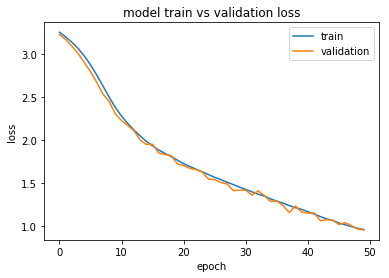

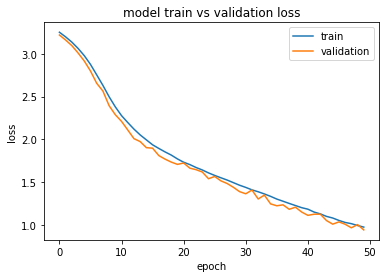

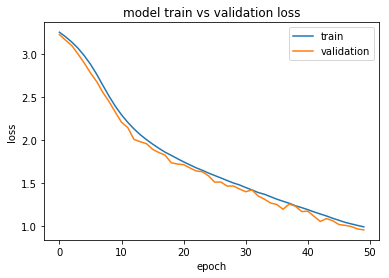

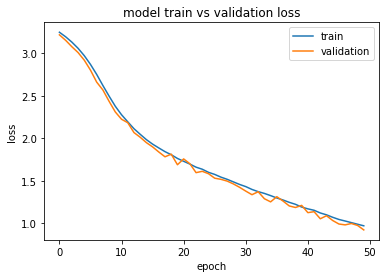

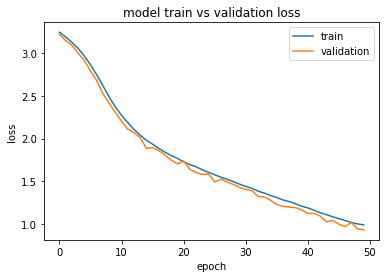

In [12]:
# plot train and validation loss
plt.plot(lloogg_1['train']['epoch'], lloogg_1['train']['loss'])
plt.plot(lloogg_1['val']['epoch'], lloogg_1['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(lloogg_2['train']['epoch'], lloogg_2['train']['loss'])
plt.plot(lloogg_2['val']['epoch'], lloogg_2['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(lloogg_3['train']['epoch'], lloogg_3['train']['loss'])
plt.plot(lloogg_3['val']['epoch'], lloogg_3['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(lloogg_4['train']['epoch'], lloogg_4['train']['loss'])
plt.plot(lloogg_4['val']['epoch'], lloogg_4['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(lloogg_5['train']['epoch'], lloogg_5['train']['loss'])
plt.plot(lloogg_5['val']['epoch'], lloogg_5['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

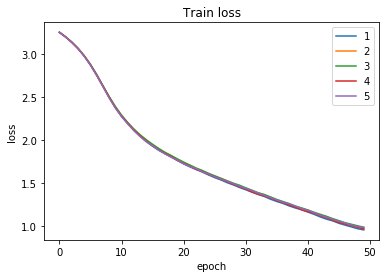

In [13]:
plt.plot(lloogg_1['train']['epoch'], lloogg_1['train']['loss'])
plt.plot(lloogg_2['train']['epoch'], lloogg_2['train']['loss'])
plt.plot(lloogg_3['train']['epoch'], lloogg_3['train']['loss'])
plt.plot(lloogg_4['train']['epoch'], lloogg_4['train']['loss'])
plt.plot(lloogg_5['train']['epoch'], lloogg_5['train']['loss'])
# plt.plot(lloogg_1['val']['epoch'], lloogg_1['val']['loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['1','2','3','4','5'], loc='upper right')
plt.show()

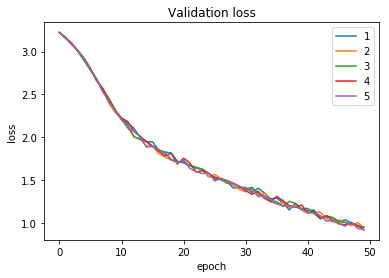

In [14]:
plt.plot(lloogg_1['val']['epoch'], lloogg_1['val']['loss'])
plt.plot(lloogg_2['val']['epoch'], lloogg_2['val']['loss'])
plt.plot(lloogg_3['val']['epoch'], lloogg_3['val']['loss'])
plt.plot(lloogg_4['val']['epoch'], lloogg_4['val']['loss'])
plt.plot(lloogg_5['val']['epoch'], lloogg_5['val']['loss'])
# plt.plot(lloogg_1['val']['epoch'], lloogg_1['val']['loss'])
plt.title('Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['1','2','3','4','5'], loc='upper right')
plt.show()

In [15]:
result_record_f1 = pd.DataFrame.from_dict(data=result_f1, orient='index')
result_record_f1 = np.mean(np.array(result_record_f1), axis = 0)
result_record_f1 = result_record_f1.reshape(-1)

result_record_acc = pd.DataFrame.from_dict(data=result_acc, orient='index')
result_record_acc = np.mean(np.array(result_record_acc), axis = 0)
result_record_acc = result_record_acc.reshape(-1)

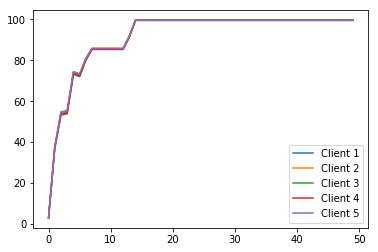

In [16]:
for i in range(client_num):
    plt.plot(np.arange(args.iters), result_acc[i], label = 'Client '+ str(i+1))
plt.legend()
plt.show()

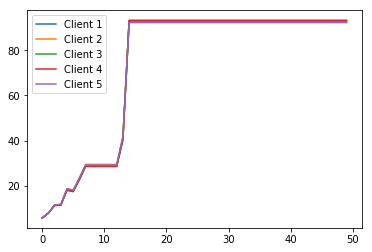

In [17]:
for i in range(client_num):
    plt.plot(np.arange(args.iters), result_f1[i], label =  'Client '+ str(i+1))
plt.legend()
plt.show()